In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid') 
font = {'weight' : 'bold', 'size' : 23}
matplotlib.rc('font', **font)
plt.style.use('seaborn')

pd.set_option('display.max_columns',0)

import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import pmdarima as pm

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import plotly.express as px
import plotly.graph_objects as go 
# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


C:\Users\ifeol\AppData\Local\Temp\ipykernel_20472\3513659339.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Functions

In [5]:
def decomposition_plot(ts):
# Apply seasonal_decompose 
    decomposition = seasonal_decompose(np.log(ts))
    
# Get trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

# Plotting
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

In [6]:
def plot_acf_pacf(ts, figsize=(10,8),lags=24):
    
    fig,ax = plt.subplots(nrows=3, figsize=figsize)
    
    # Plot ts
    ts.plot(ax=ax[0])
    
    # Plot acf, pavf
    sgt.plot_acf(ts, ax=ax[1], lags=lags)
    sgt.plot_pacf(ts, ax=ax[2], lags=lags) 
    fig.tight_layout()
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    return fig,ax

### Importing data

In [7]:
df = pd.read_csv('data-1672842356480.csv')
df.drop('item_id', axis=1, inplace=True)
df.head()


,date,return_date,gare,item_cat,item,found_not_found
0,2016-01-02 09:21:19,NaN,Lille Europe,"Porte-monnaie / portefeuille, argent, titres",Carte de crédit,Objet trouvé
1,2016-01-02 09:27:47,NaN,Lille Europe,"Porte-monnaie / portefeuille, argent, titres",Carte de crédit,Objet trouvé
2,2016-01-03 06:37:37,2016-01-26 11:13:51,Lille Europe,"Porte-monnaie / portefeuille, argent, titres","Porte-monnaie, portefeuille",Objet trouvé
3,2016-01-03 07:03:06,NaN,Lille Europe,"Articles de sport, loisirs, camping",Bâton de marche,Objet trouvé
4,2016-01-04 09:36:28,NaN,Lille Europe,"Bagagerie: sacs, valises, cartables","Valise, sac sur roulettes",Objet trouvé


<AxesSubplot: >

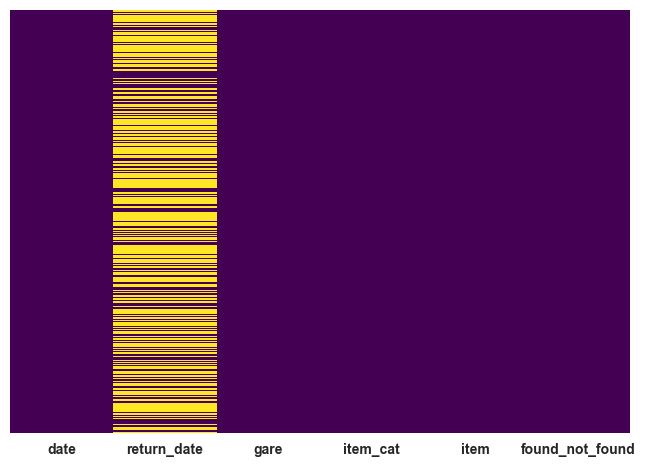

In [8]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [9]:
df['date'] = pd.to_datetime(df.date)
df['return_date'] = pd.to_datetime(df.return_date)

In [10]:
df.head()

,date,return_date,gare,item_cat,item,found_not_found
0,2016-01-02 09:21:19,NaT,Lille Europe,"Porte-monnaie / portefeuille, argent, titres",Carte de crédit,Objet trouvé
1,2016-01-02 09:27:47,NaT,Lille Europe,"Porte-monnaie / portefeuille, argent, titres",Carte de crédit,Objet trouvé
2,2016-01-03 06:37:37,2016-01-26 11:13:51,Lille Europe,"Porte-monnaie / portefeuille, argent, titres","Porte-monnaie, portefeuille",Objet trouvé
3,2016-01-03 07:03:06,NaT,Lille Europe,"Articles de sport, loisirs, camping",Bâton de marche,Objet trouvé
4,2016-01-04 09:36:28,NaT,Lille Europe,"Bagagerie: sacs, valises, cartables","Valise, sac sur roulettes",Objet trouvé


In [11]:
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df['week'] = df.date.dt.week
df['day'] = df.date.dt.day



In [12]:
df = df[df['year'] != 2015]
df = df[df['year'] != 2023]

In [13]:
df['year']= df['year'].astype(str)
df['month']= df['month'].astype(str)
df['day']= df['day'].astype(str)

In [14]:
df['Date'] = df['year'] +'-' +df['month'] +'-'+df['day']

In [15]:
df['Date'] = pd.to_datetime(df.Date)
df['count'] = 1

### Affichez la moyenne d'objet perdu: par mois

In [16]:
df_mean_month = df.groupby(['month']).sum() / (7*12)
df_mean_month.drop(columns=['week'], axis=1, inplace=True)
df_mean_month

,count
month,
1,21.821429
10,25.035714
11,20.988095
12,20.607143
2,20.714286
3,20.226190
4,18.369048
5,20.250000
6,23.714286


### Affichez la moyenne d'objet perdu: par semaine

In [17]:
df_mean_week = df.groupby(df.date.dt.week).sum() / 54
df_mean_week.drop(columns=['week'], axis=1, inplace=True)
df_mean_week

,count
date,
1,7.574074
2,7.500000
3,7.629630
4,7.629630
5,8.240741
6,8.092593
7,8.018519
8,8.018519
9,7.407407


### Affichez la moyenne d'objet perdu: par jour par semaine

In [18]:
df_mean_dayofweek = df.groupby(df.date.dt.dayofweek).sum() / 7
df_mean_dayofweek.drop(columns=['week'], axis=1, inplace=True)
df_mean_dayofweek

,count
date,
0,574.428571
1,446.857143
2,416.000000
3,479.857143
4,455.571429
5,442.142857
6,357.857143


### Affichez la moyenne d'objet perdu: par jour par an

In [19]:
df_sum_dayofyear = df.groupby(df.date.dt.dayofyear).sum() 
df_sum_dayofyear.drop(columns=['week'], axis=1, inplace=True)
df_sum_dayofyear 

,count
date,
1,40
2,66
3,85
4,71
5,43
...,...
362,39
363,55
364,60


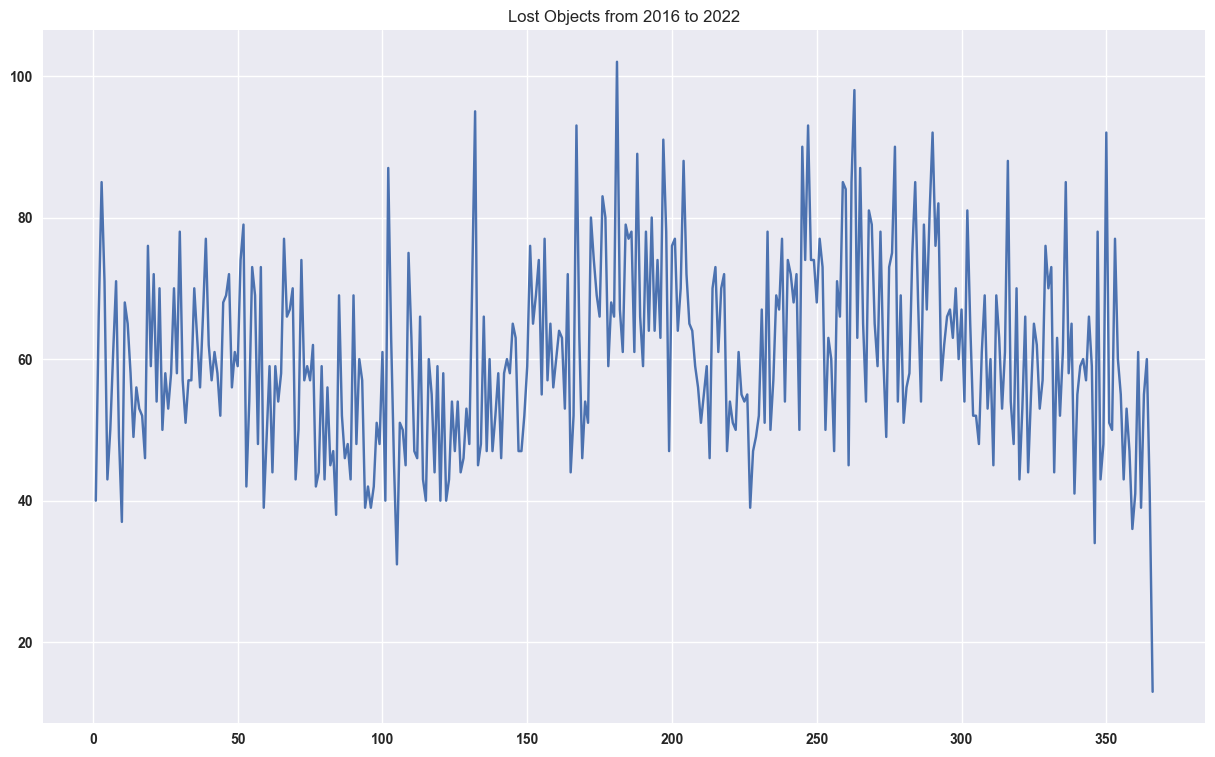

In [20]:
plt.figure(figsize=(15, 9))
plt.plot(df_sum_dayofyear)
plt.title("Lost Objects from 2016 to 2022")
plt.show()

### Affichez la moyenne d'objet perdu: par an

In [21]:
df_sum_year = df.groupby(df.date.dt.year).sum() 
df_sum_year.drop(columns=['week'], inplace=True, axis=1)
df_sum_year

,count
date,
2016,4131
2017,4623
2018,4364
2019,3005
2020,1526
2021,1915
2022,2645


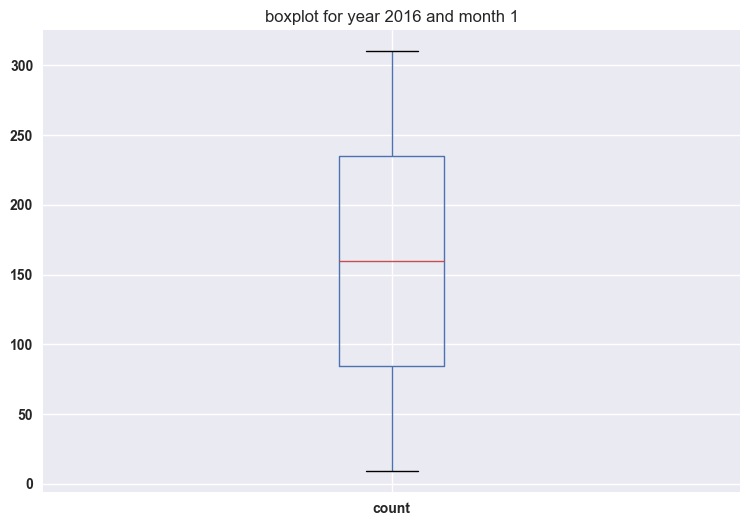

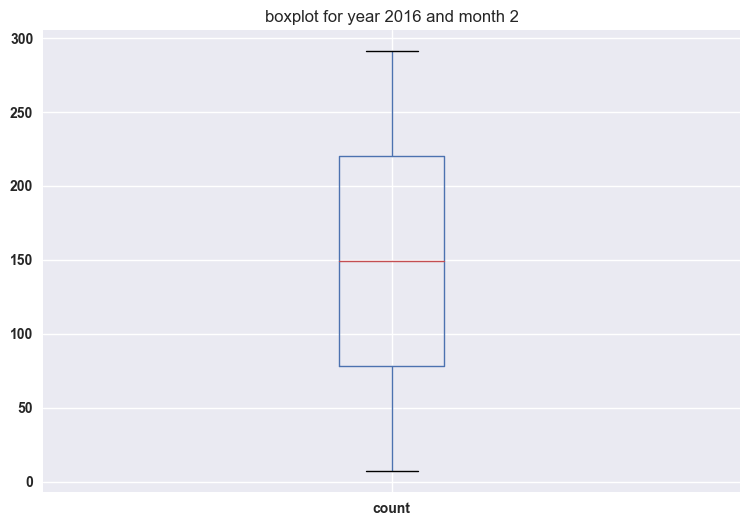

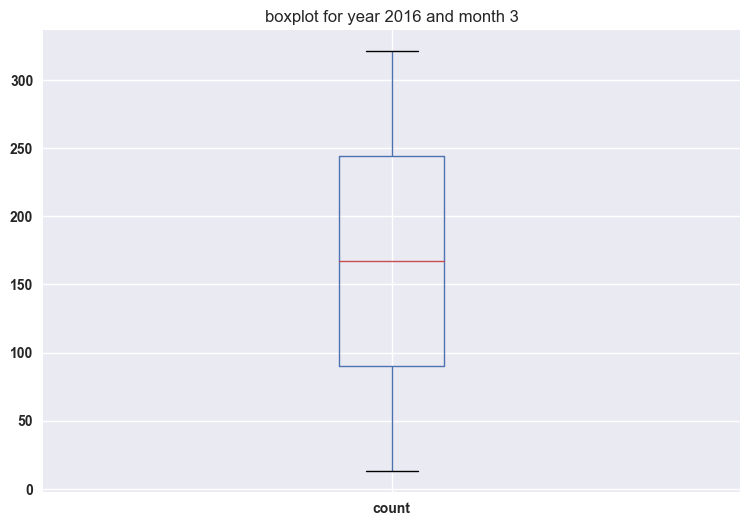

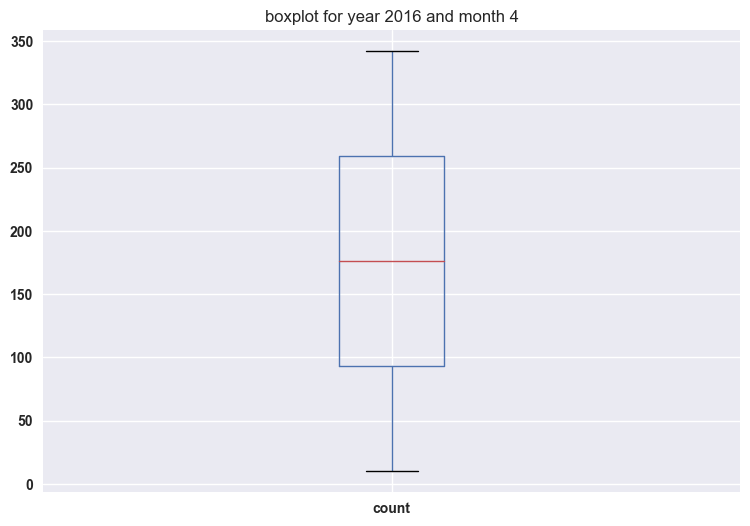

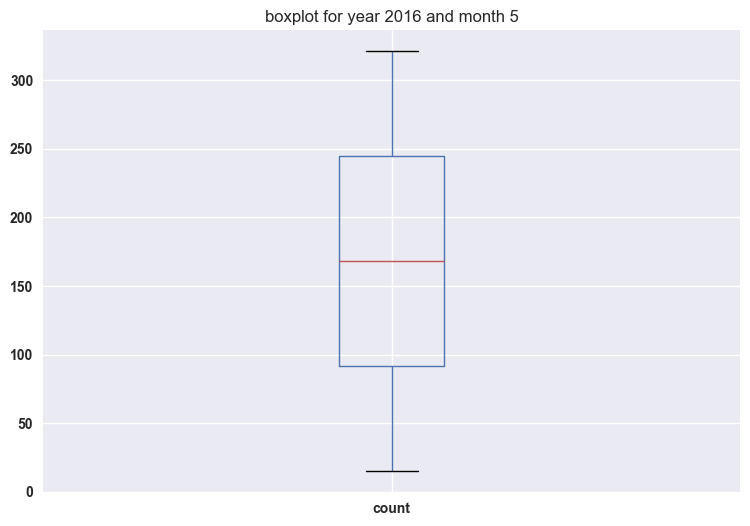

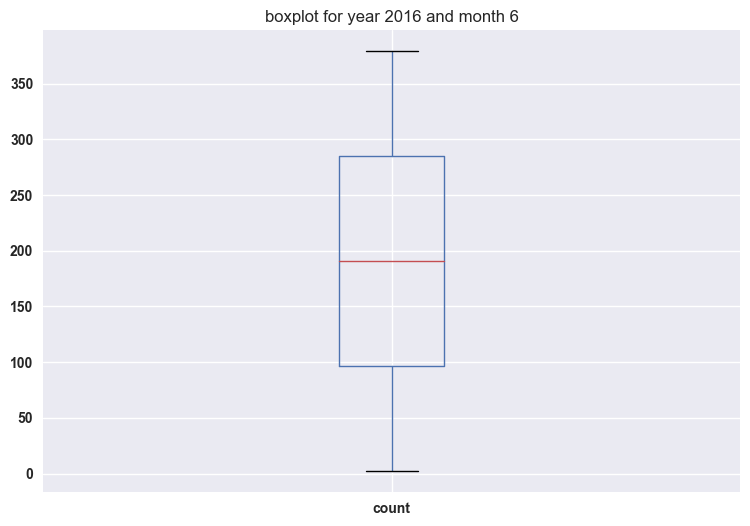

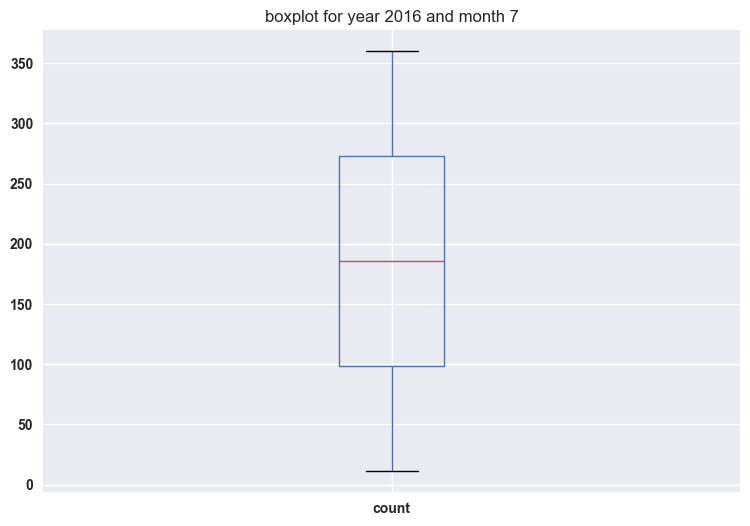

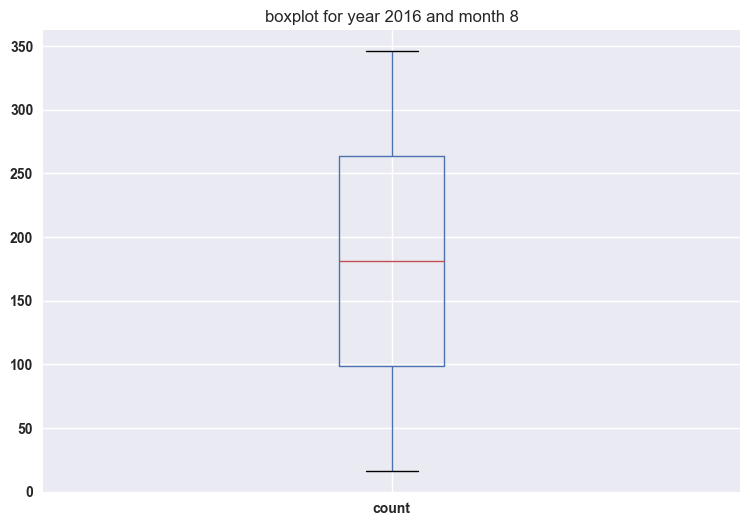

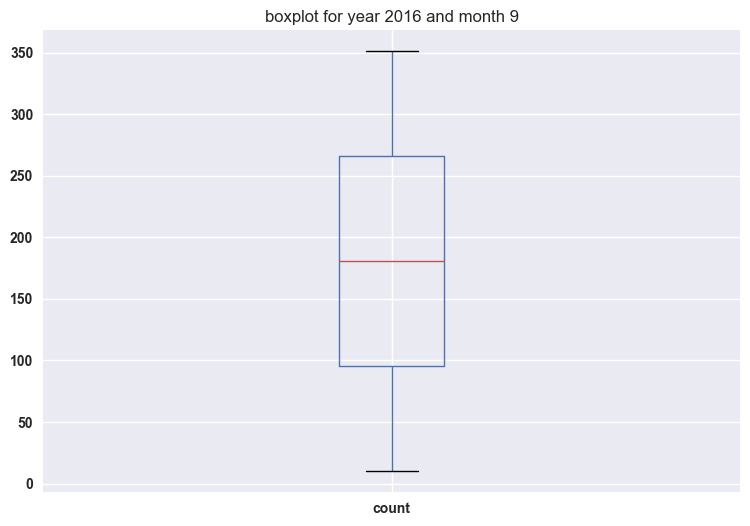

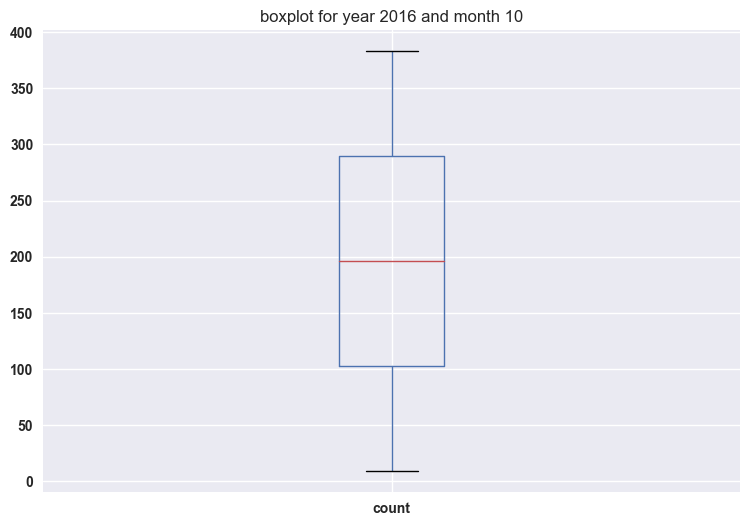

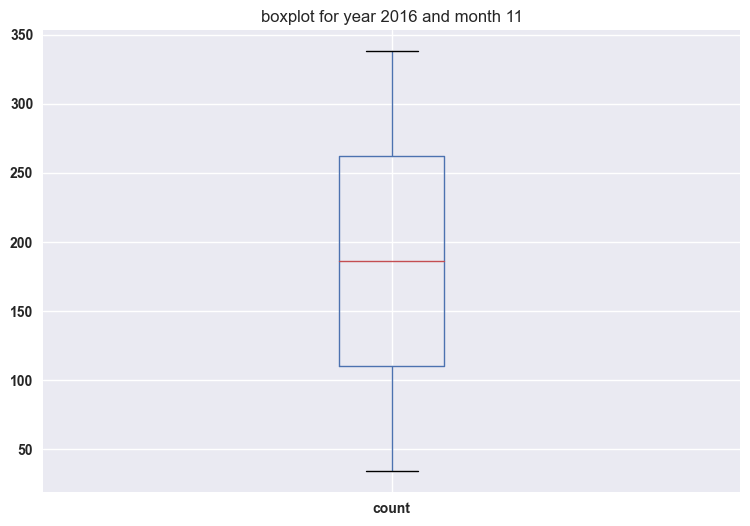

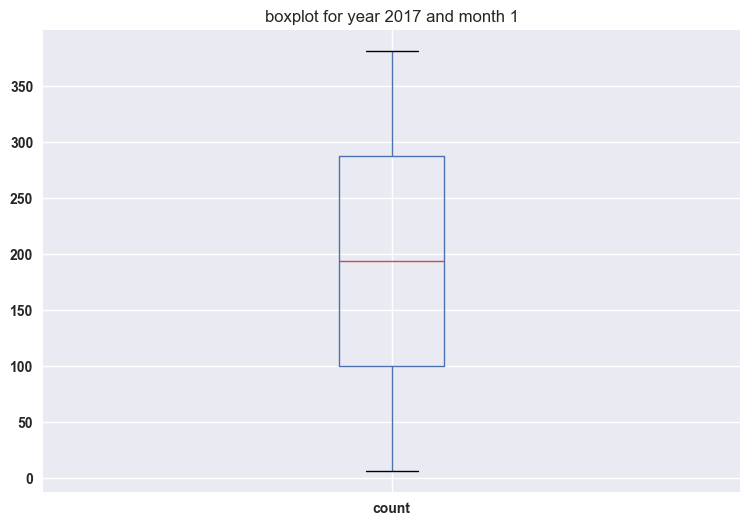

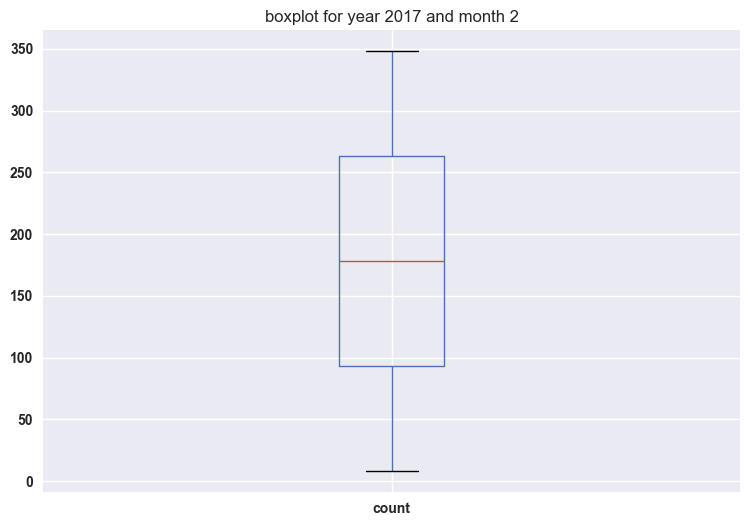

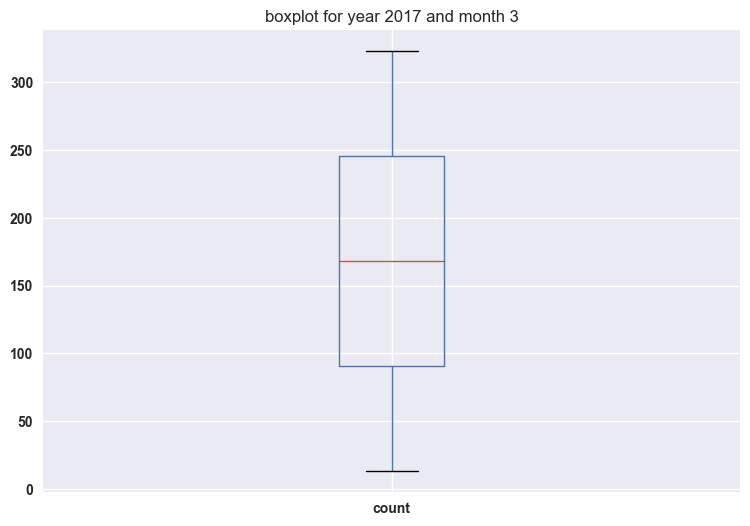

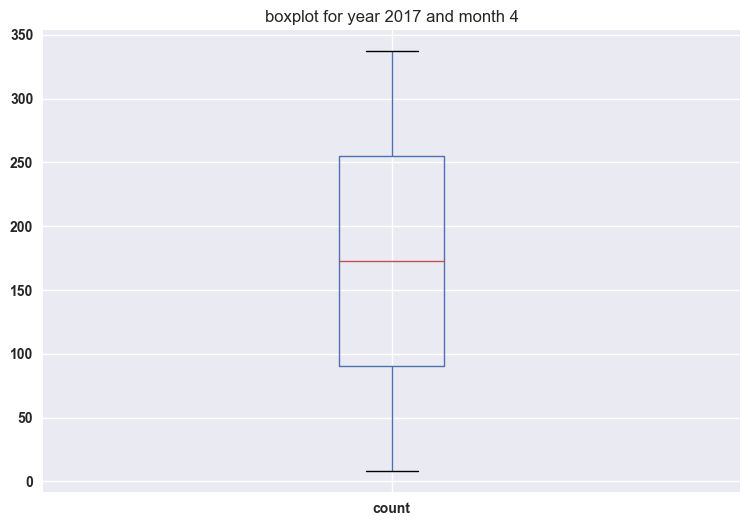

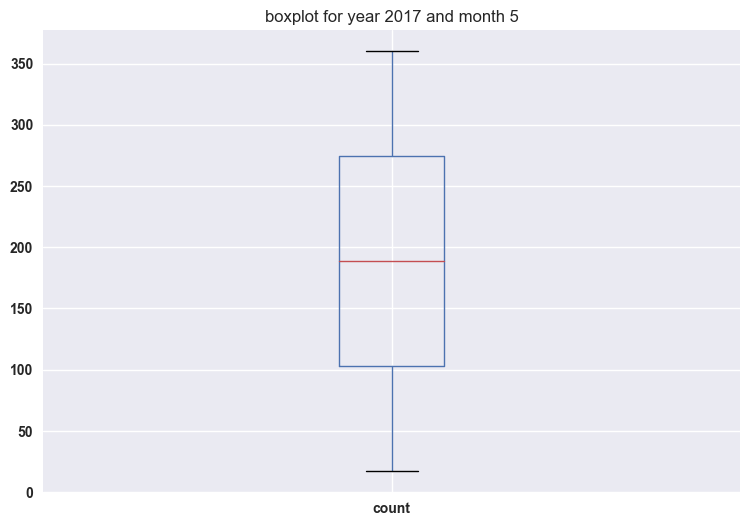

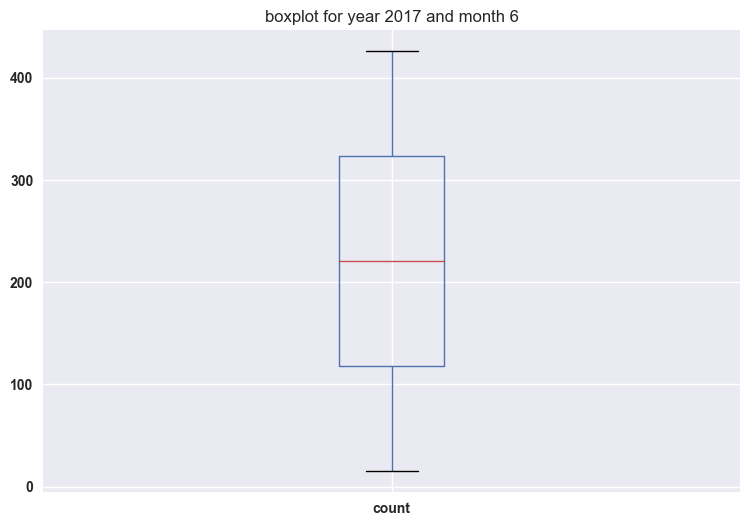

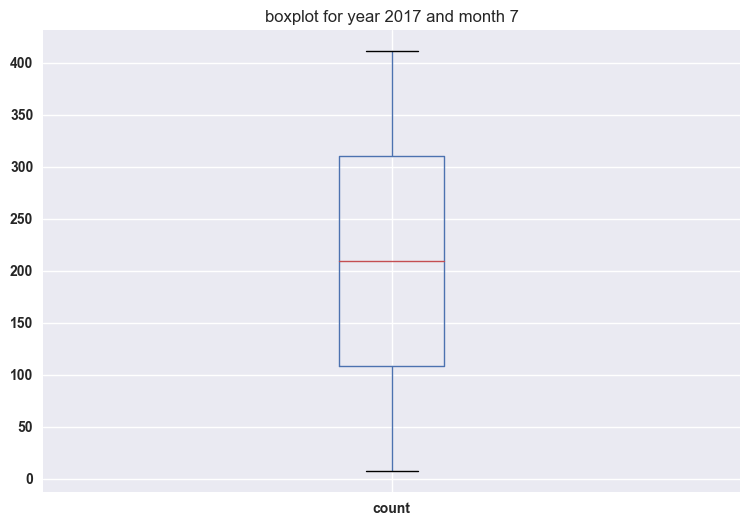

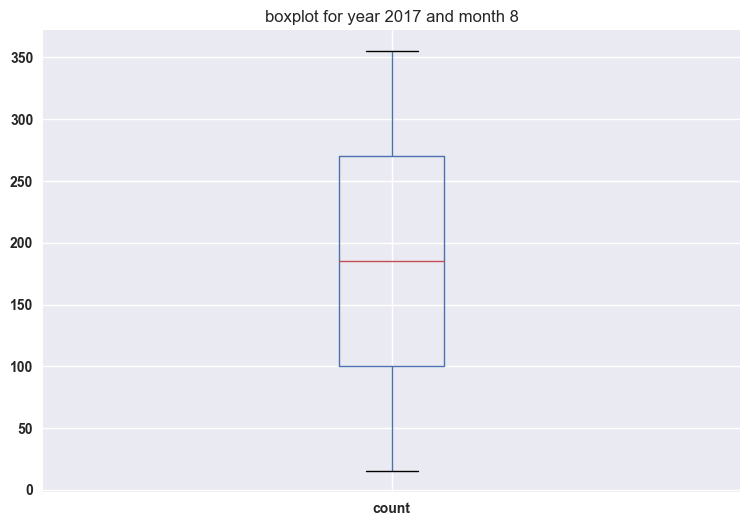

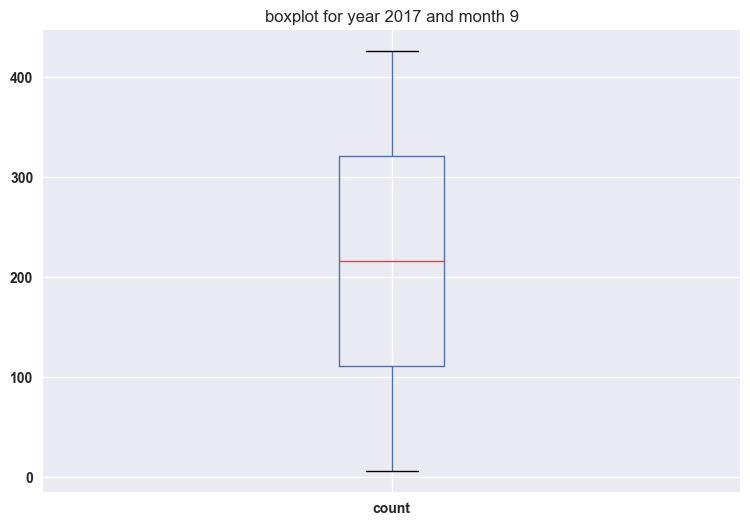

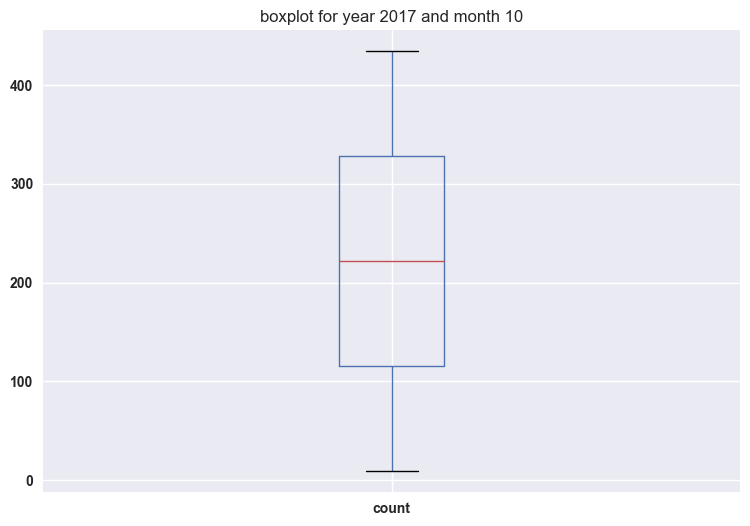

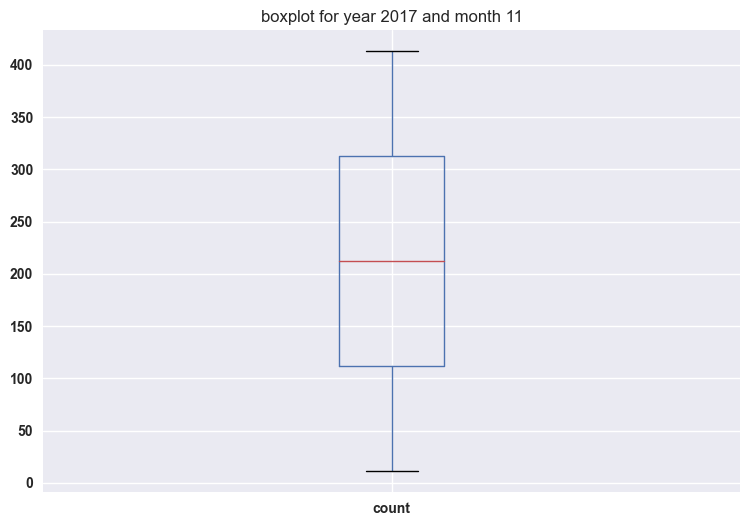

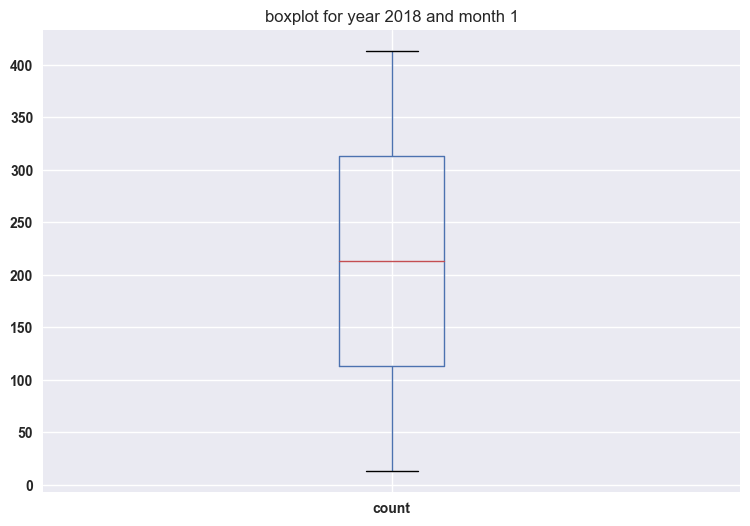

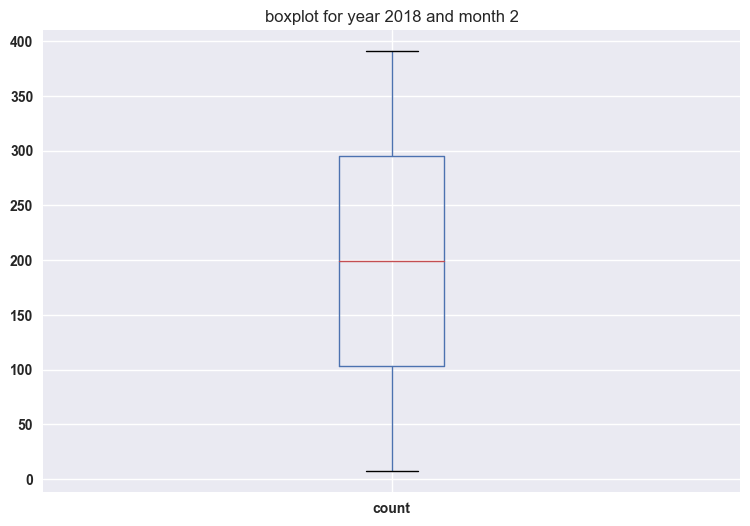

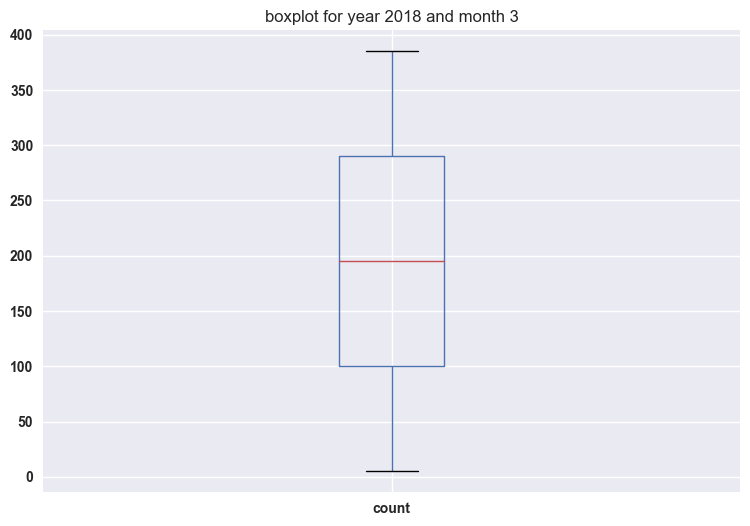

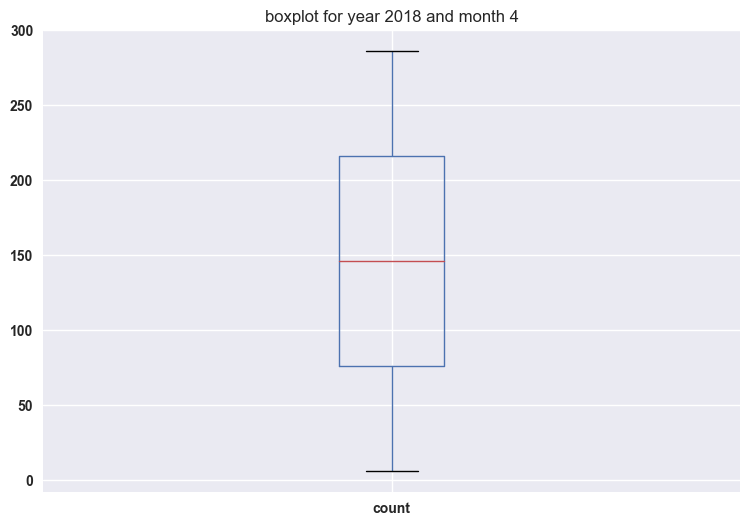

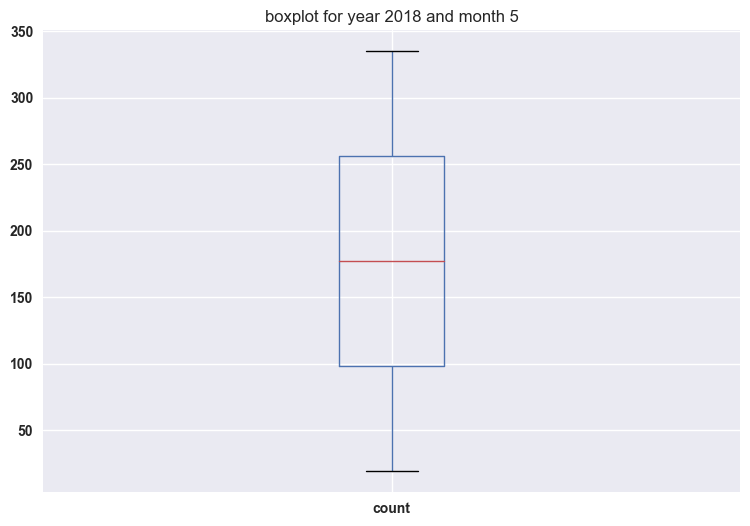

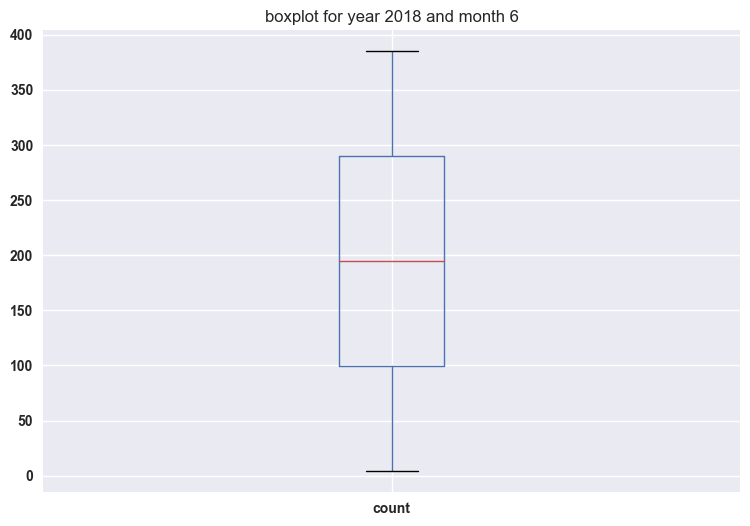

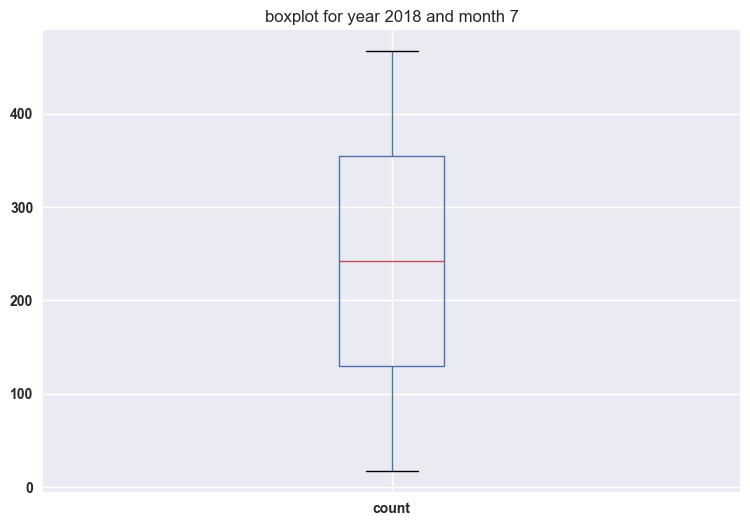

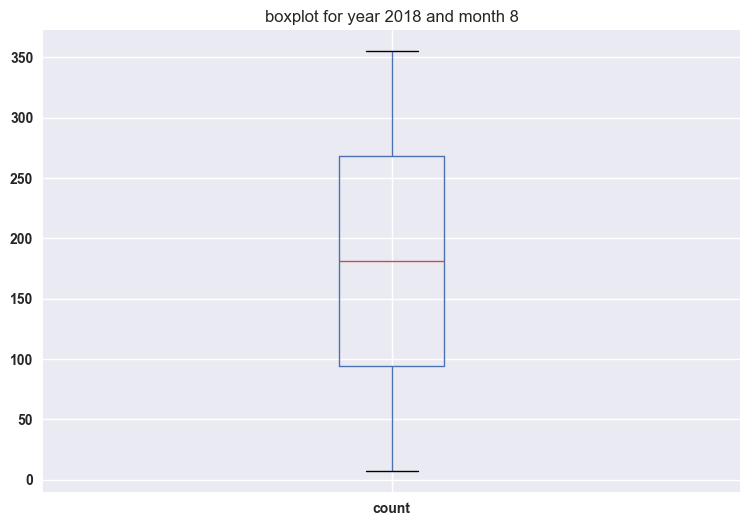

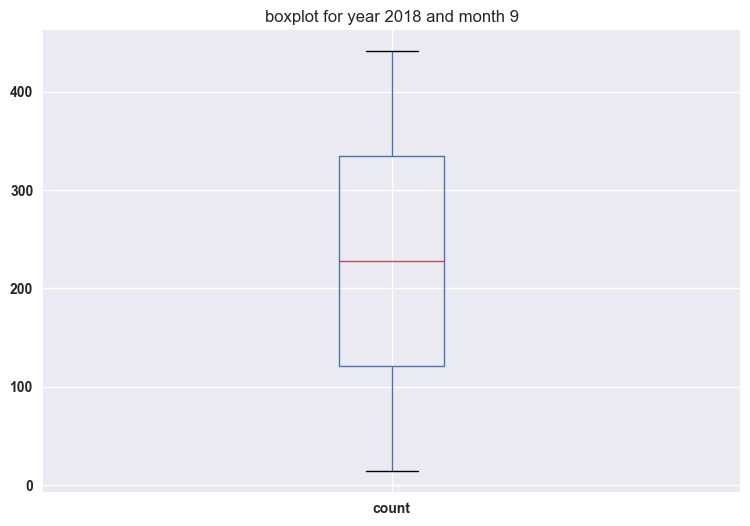

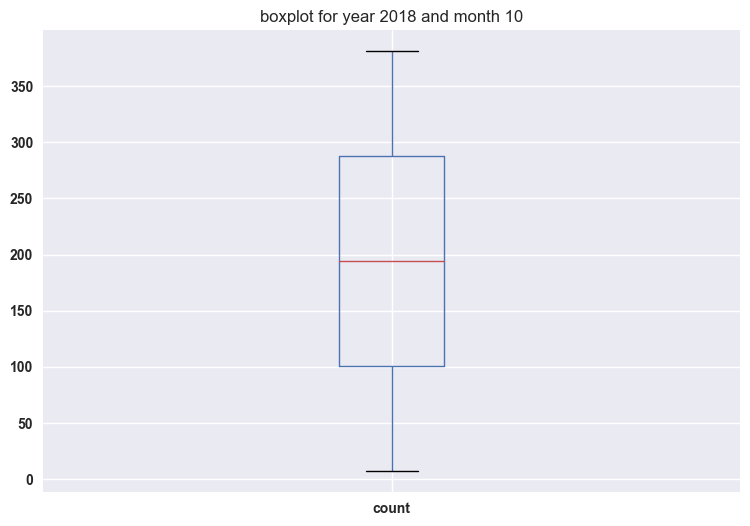

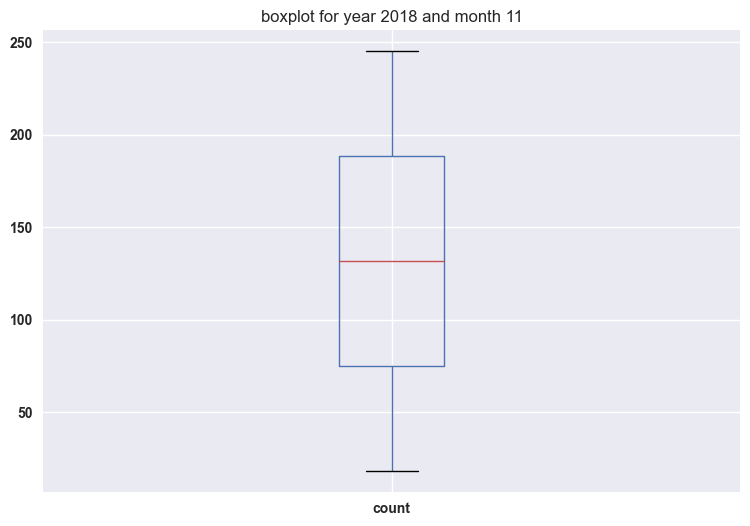

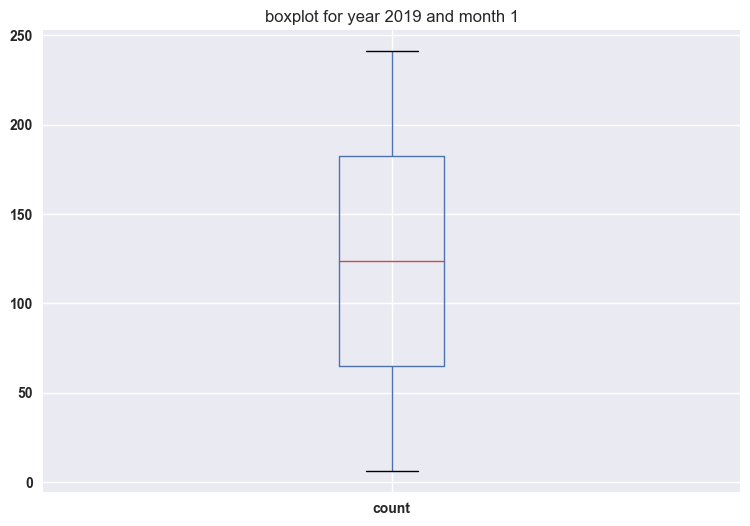

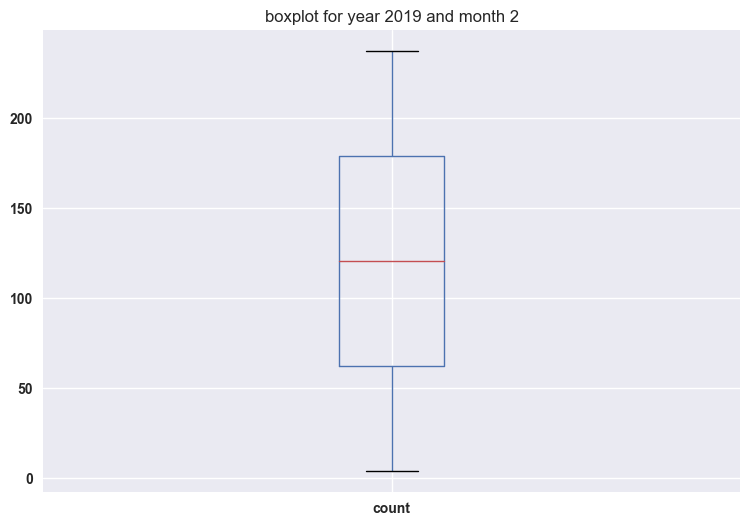

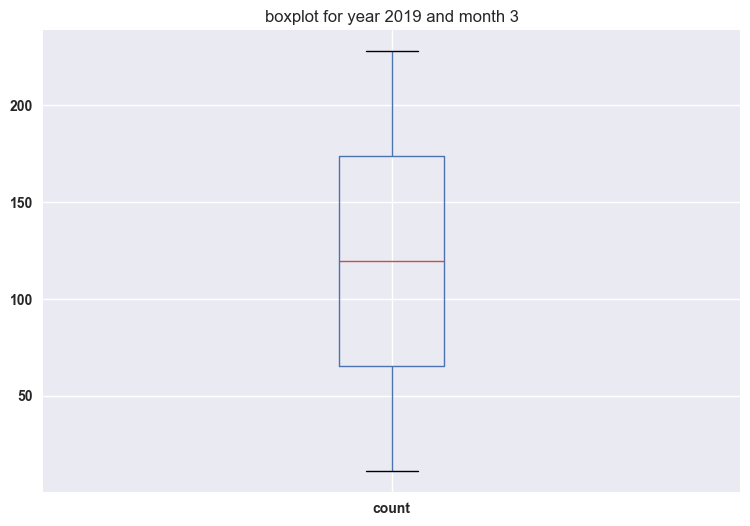

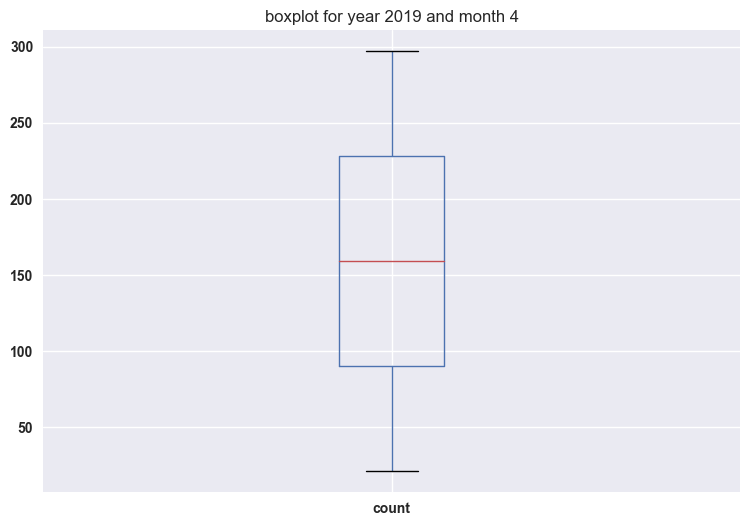

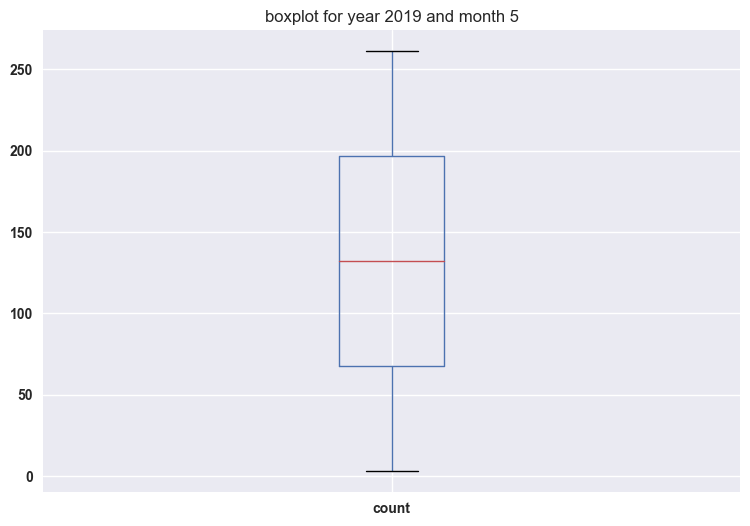

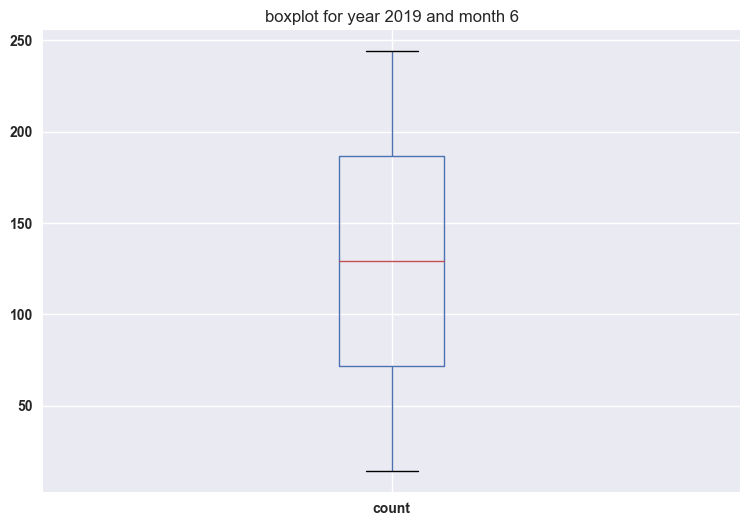

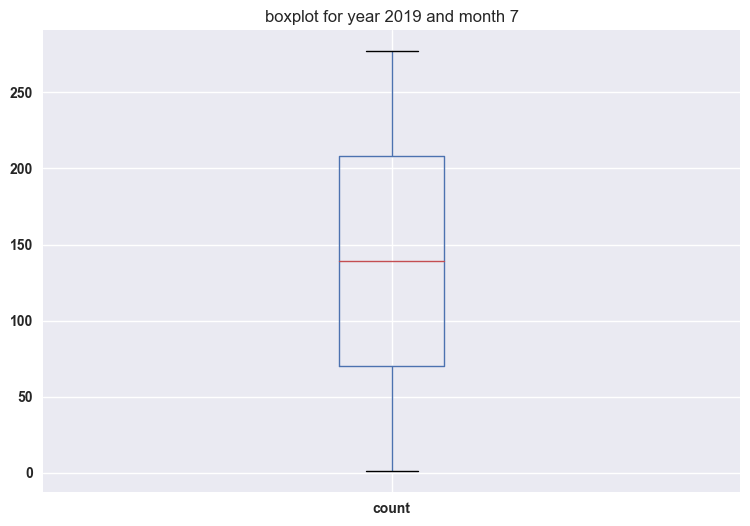

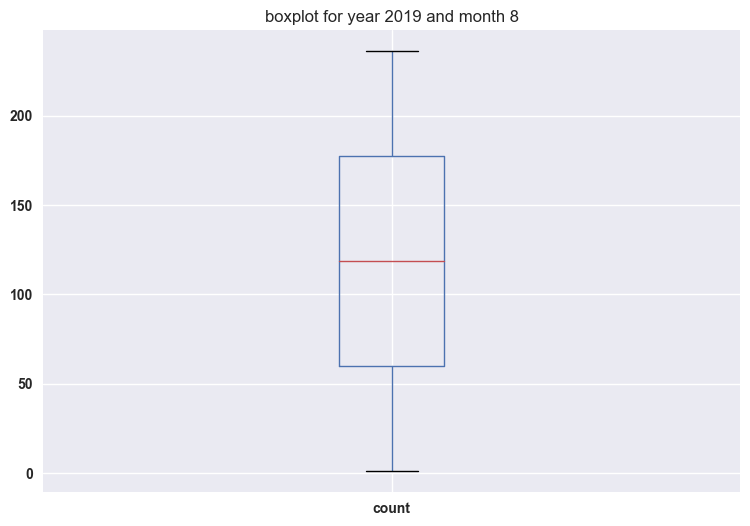

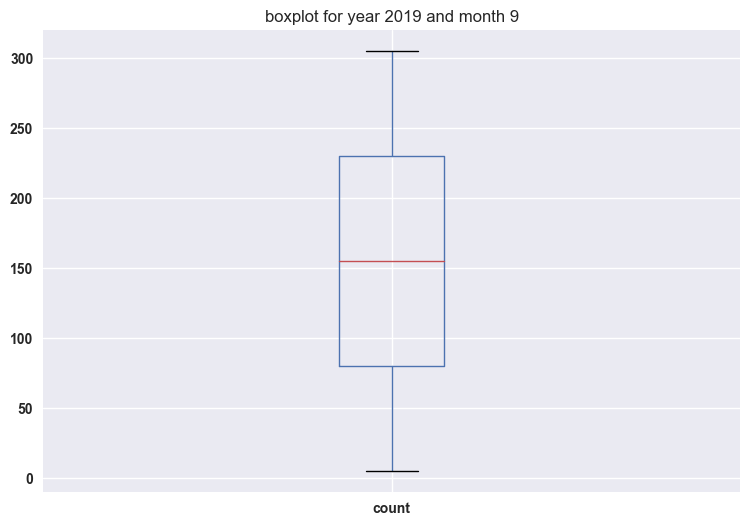

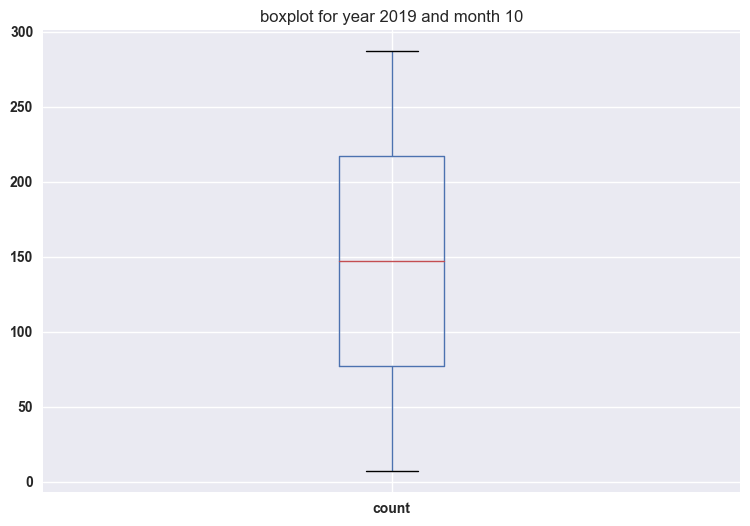

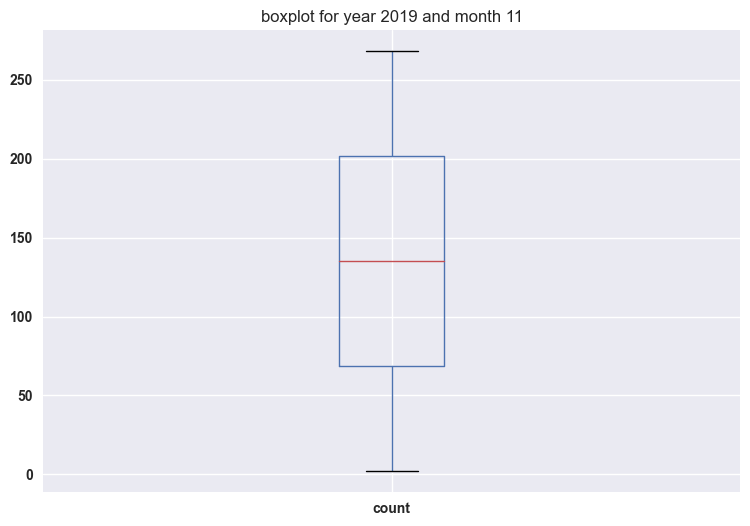

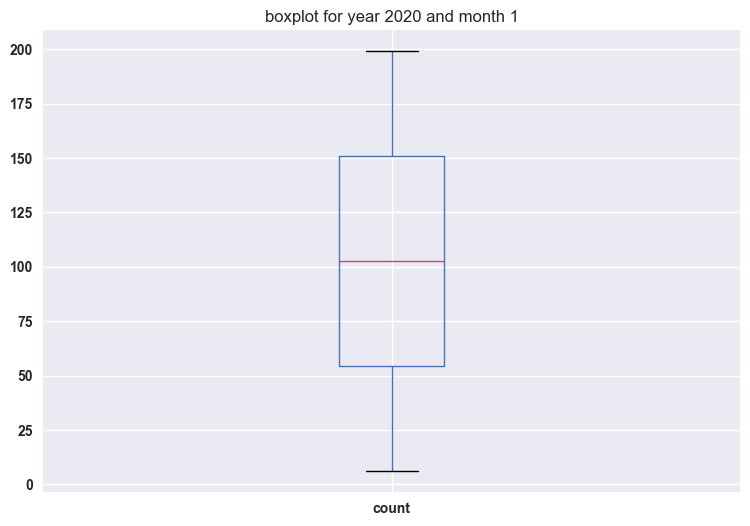

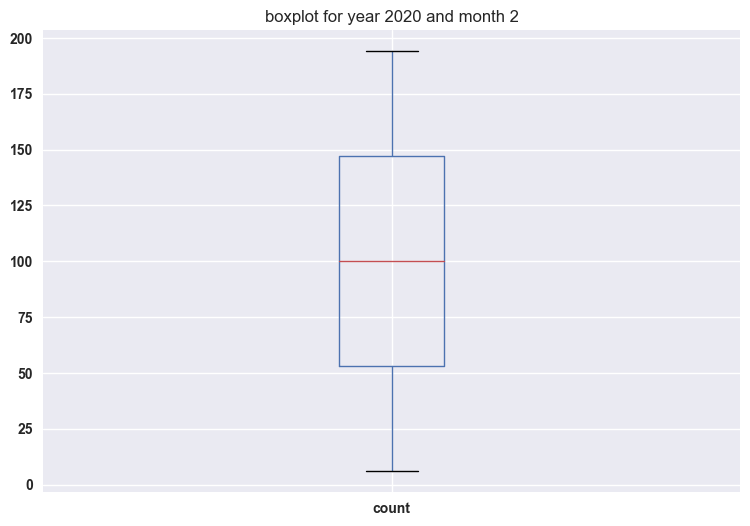

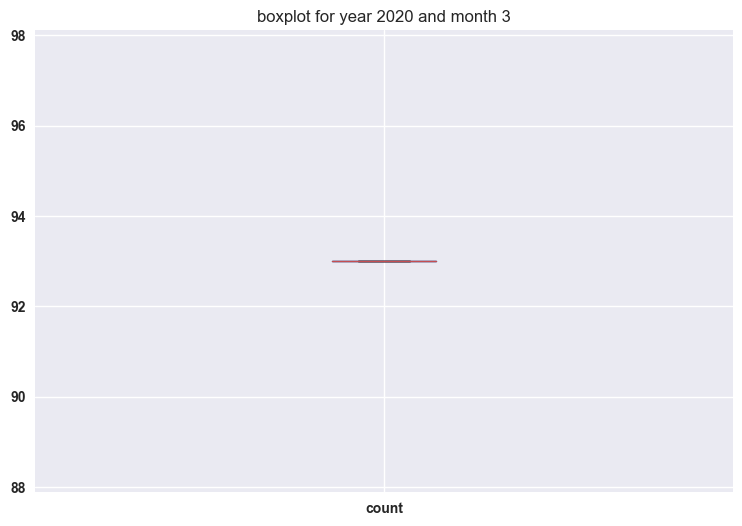

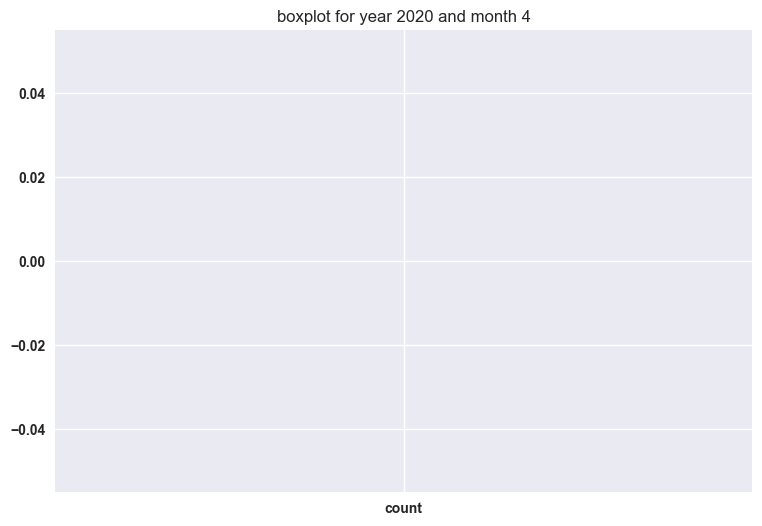

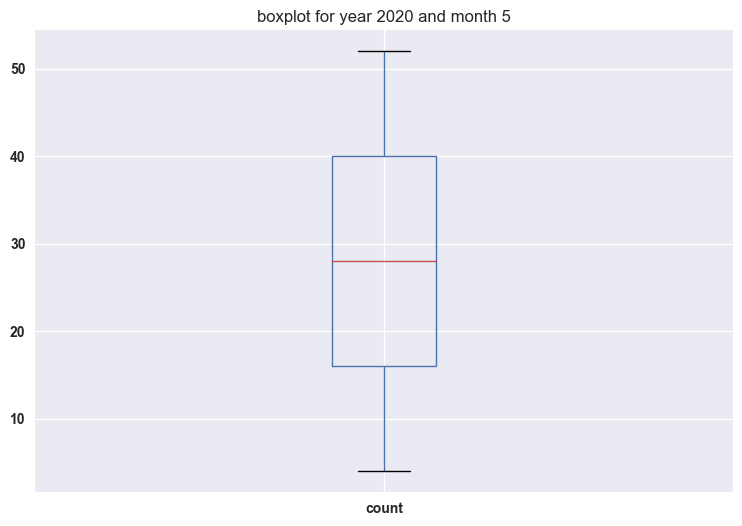

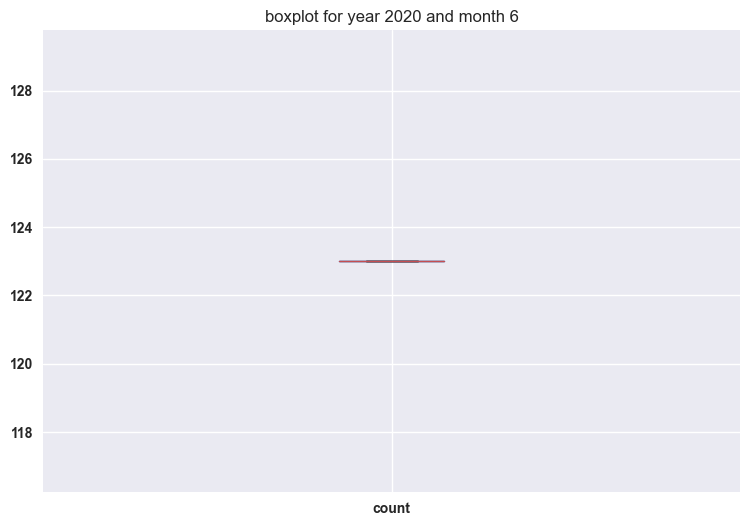

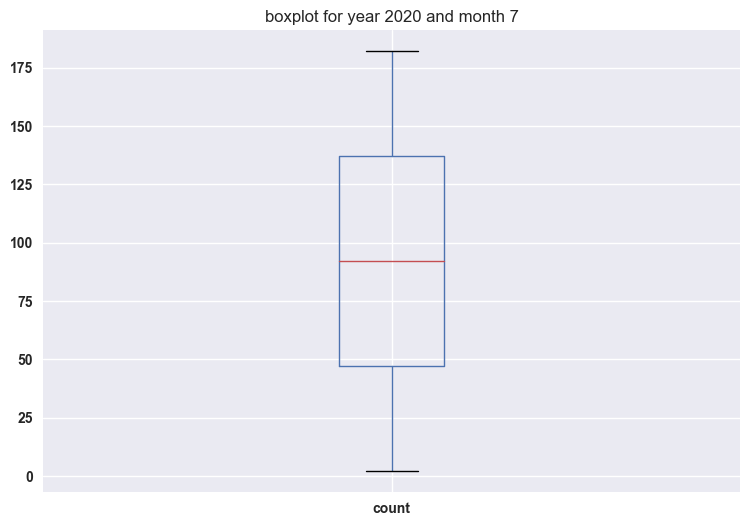

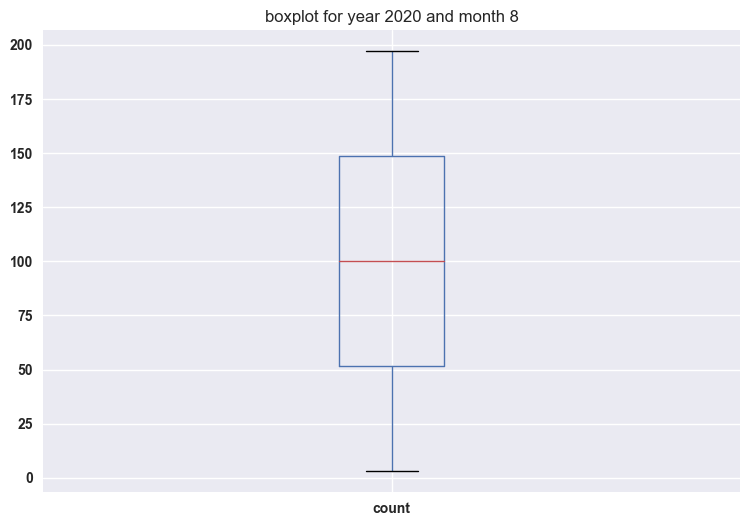

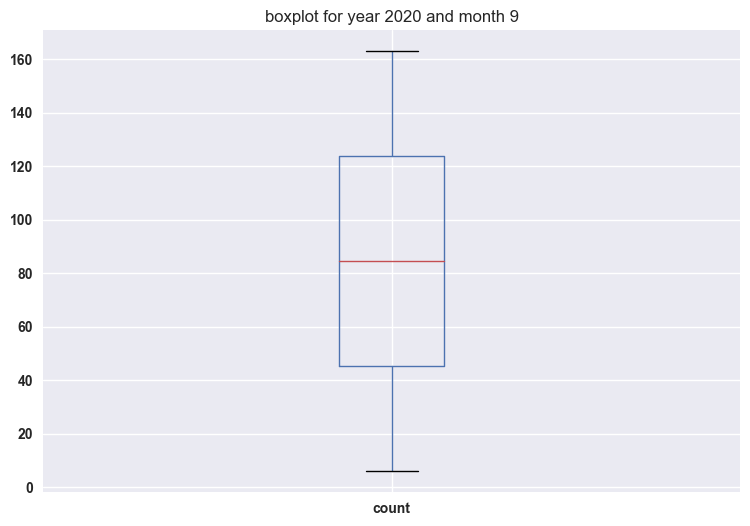

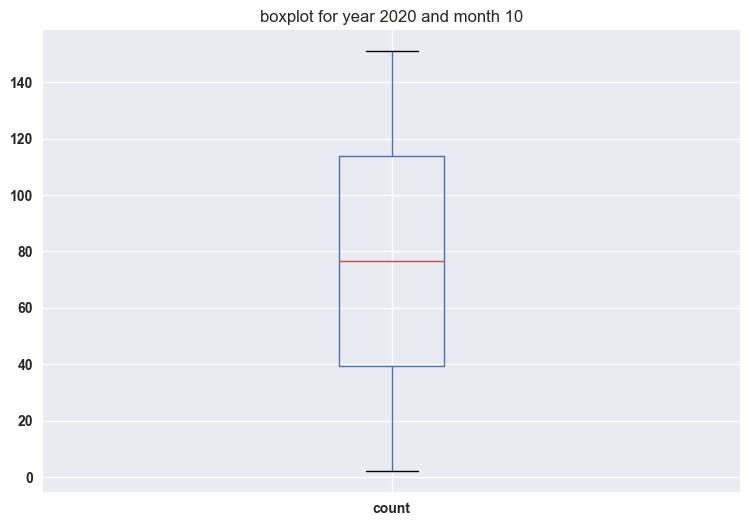

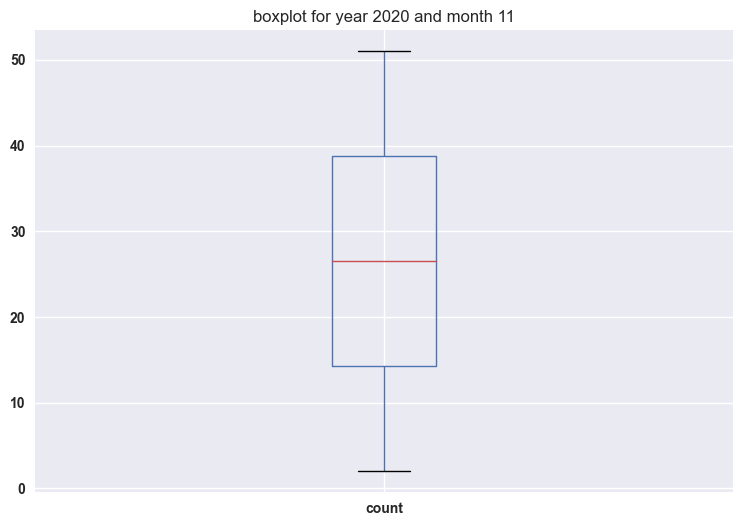

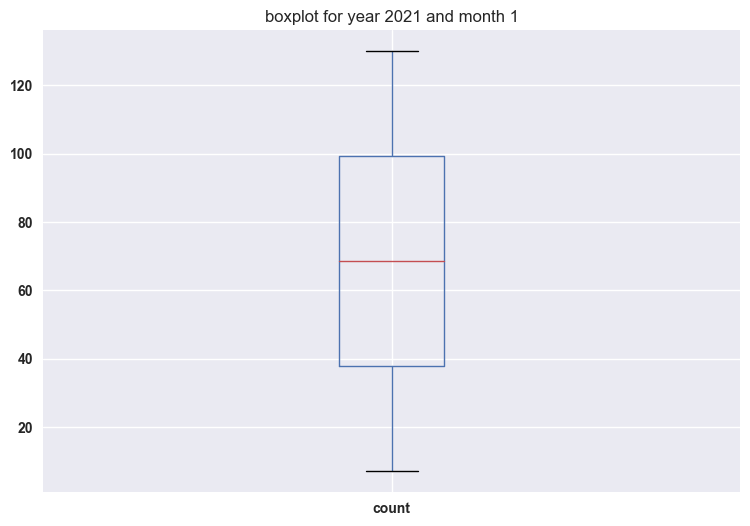

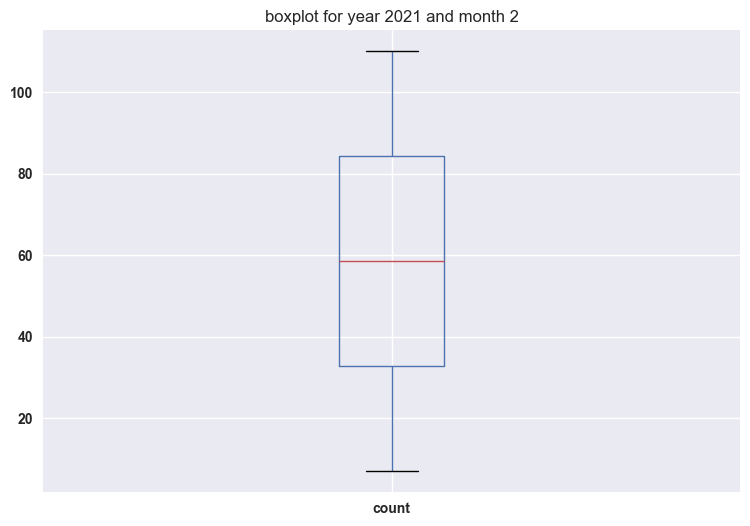

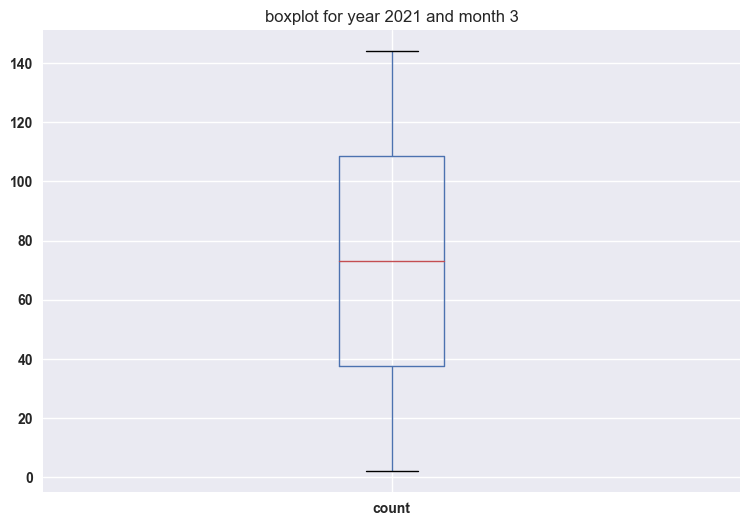

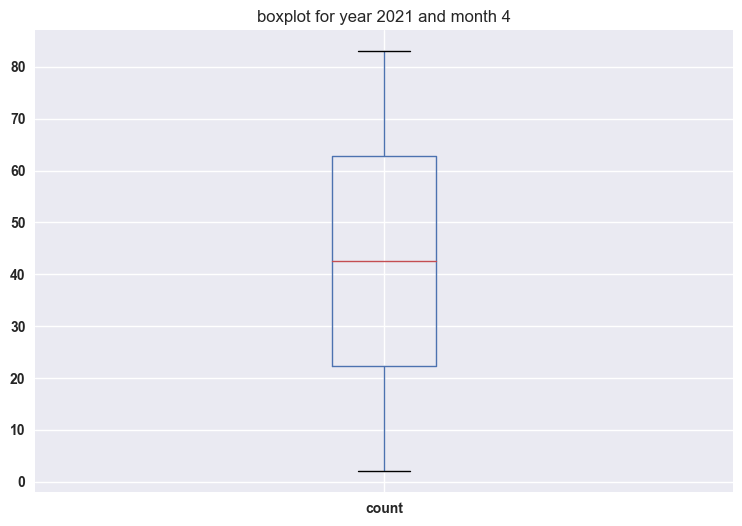

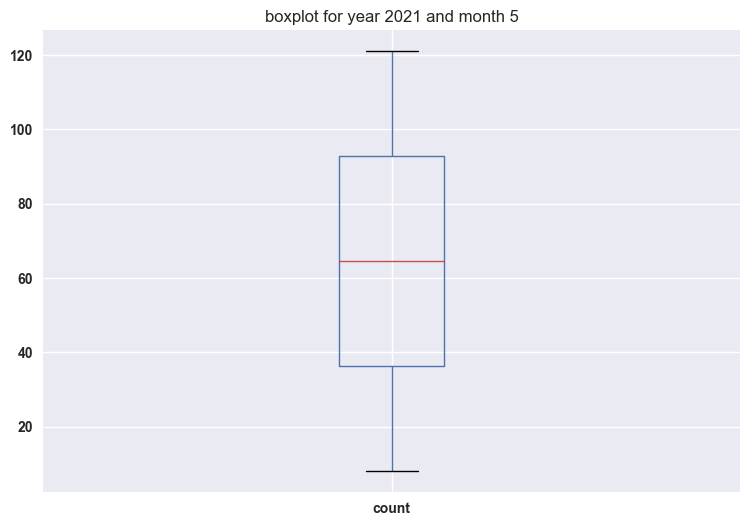

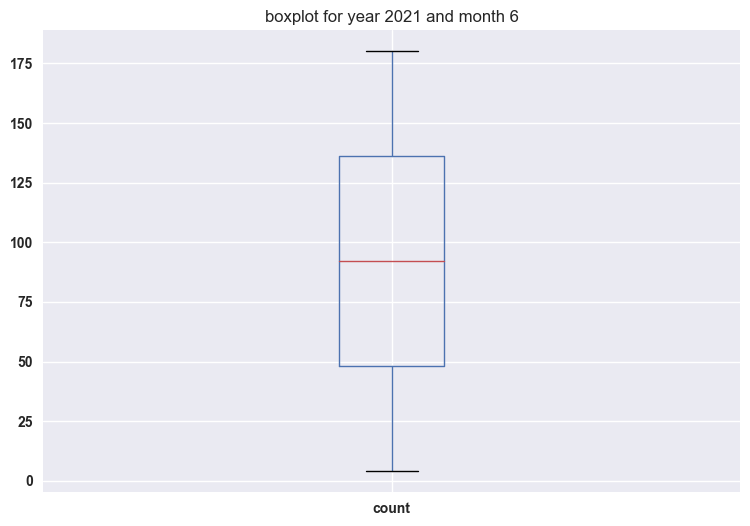

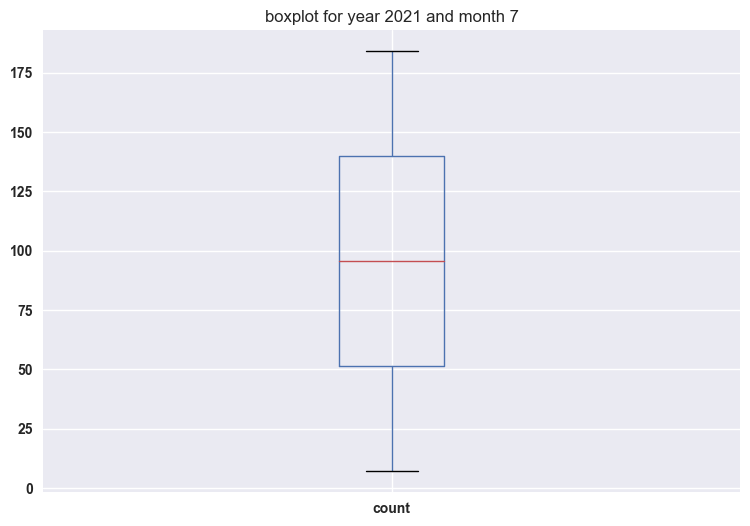

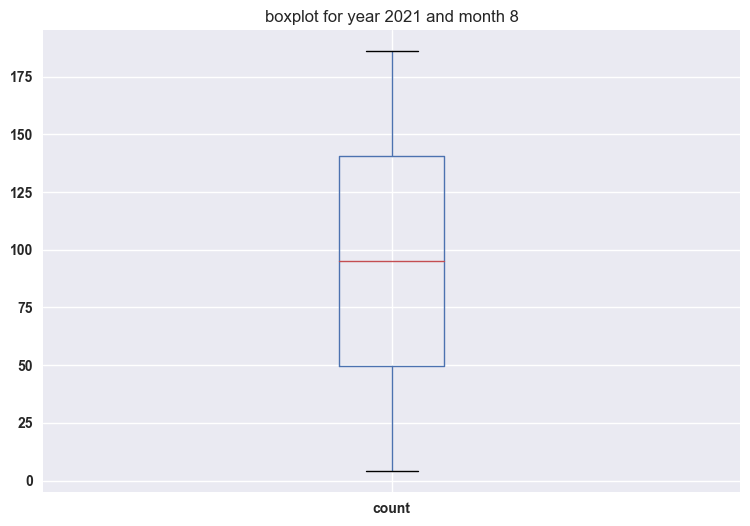

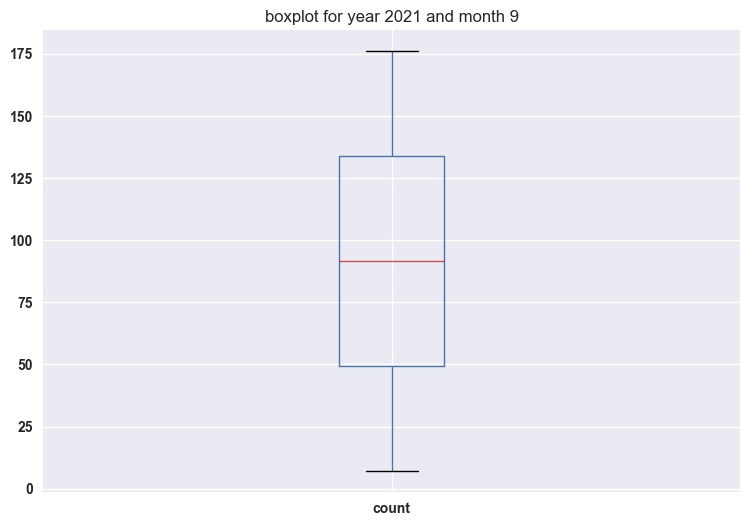

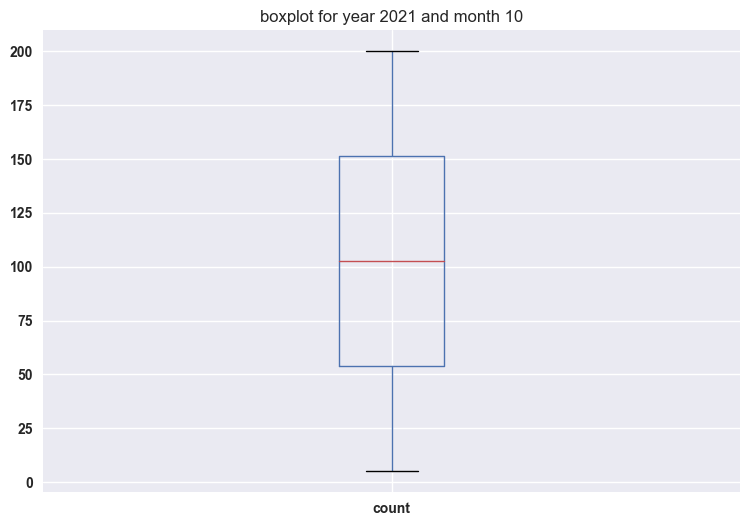

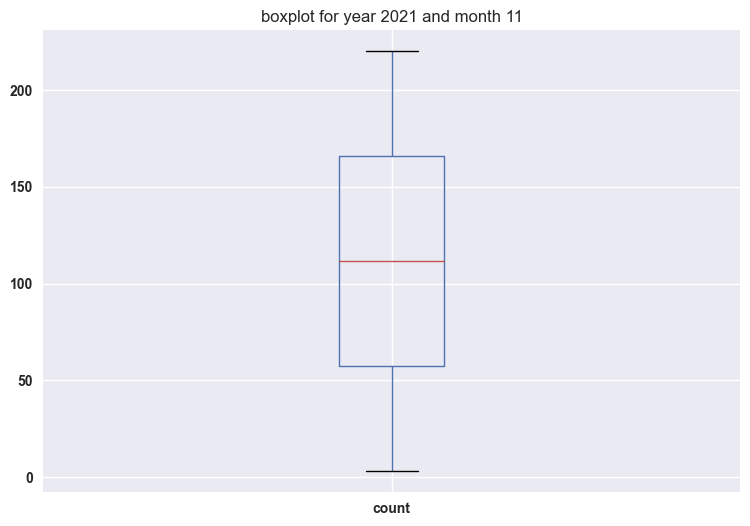

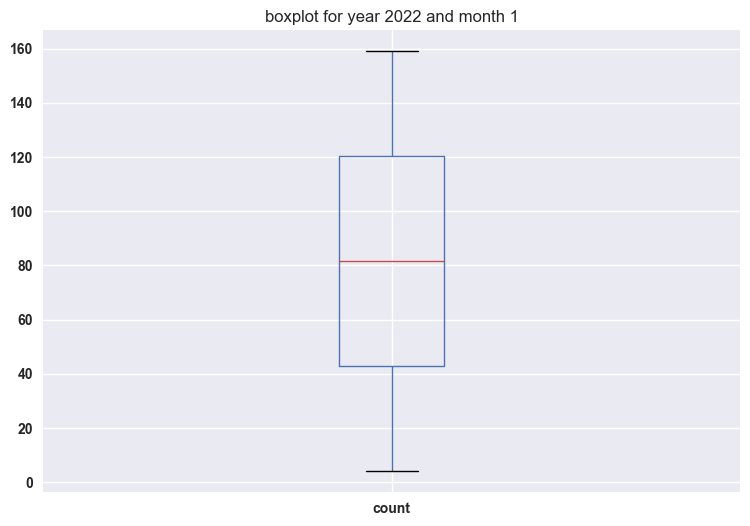

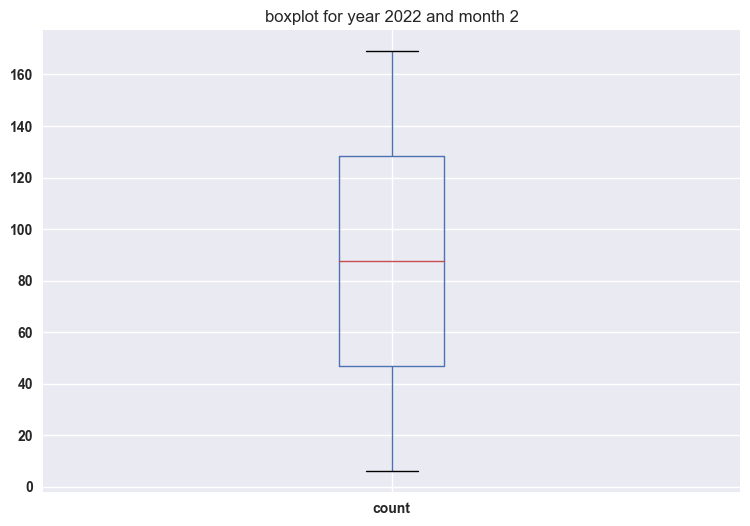

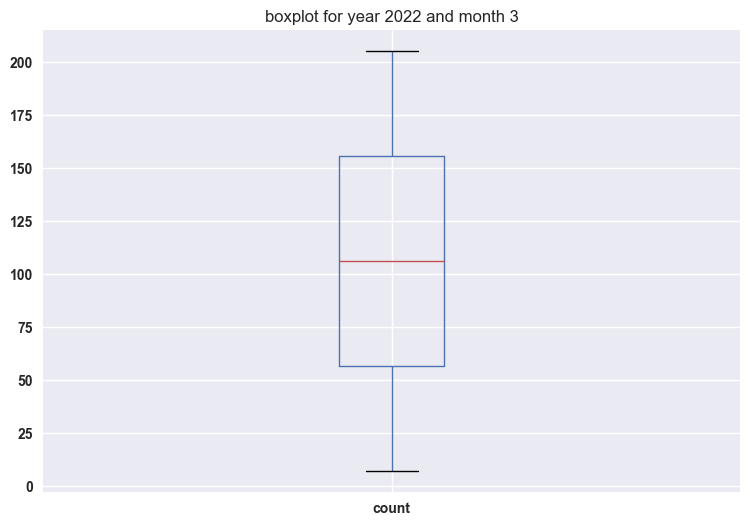

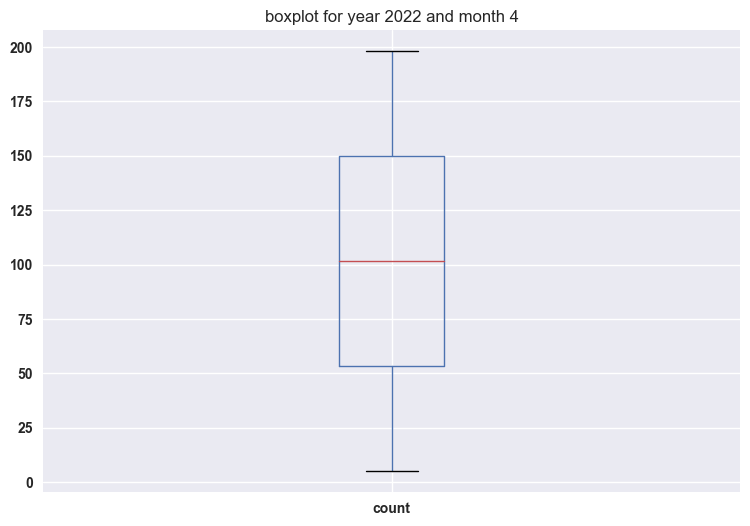

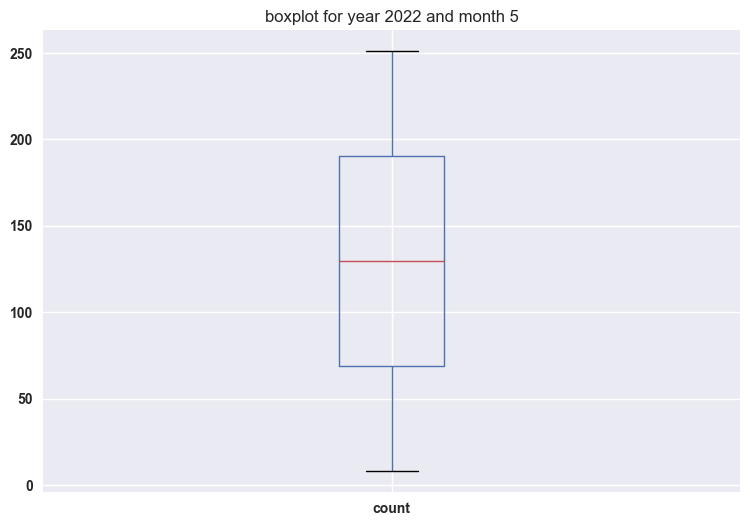

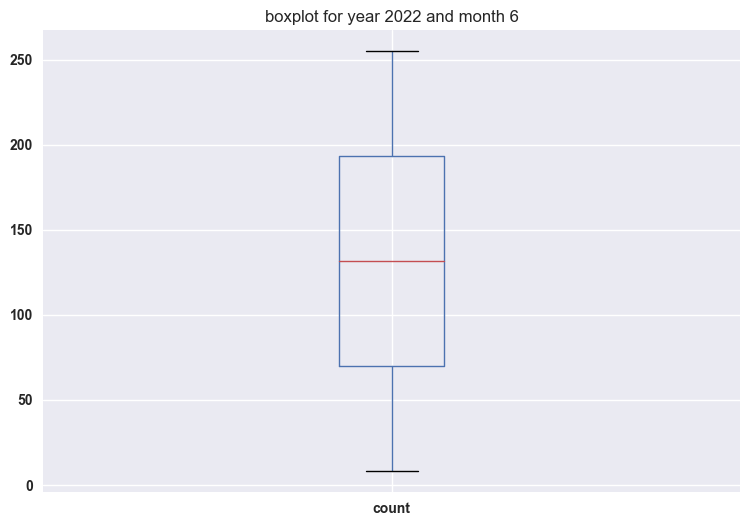

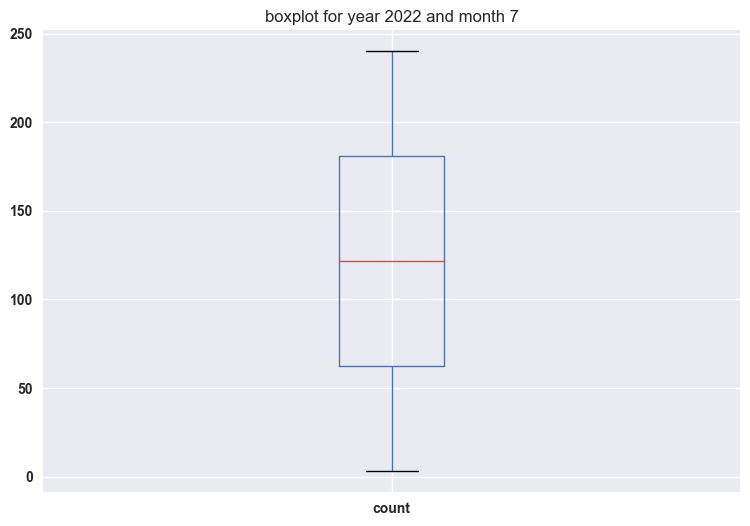

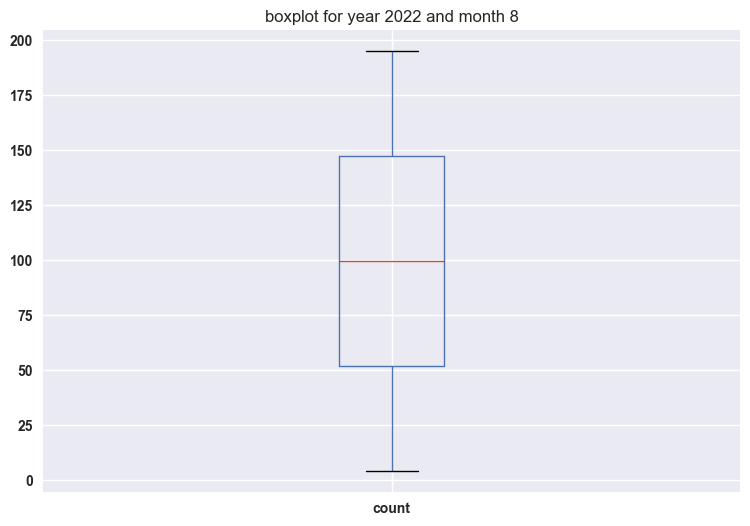

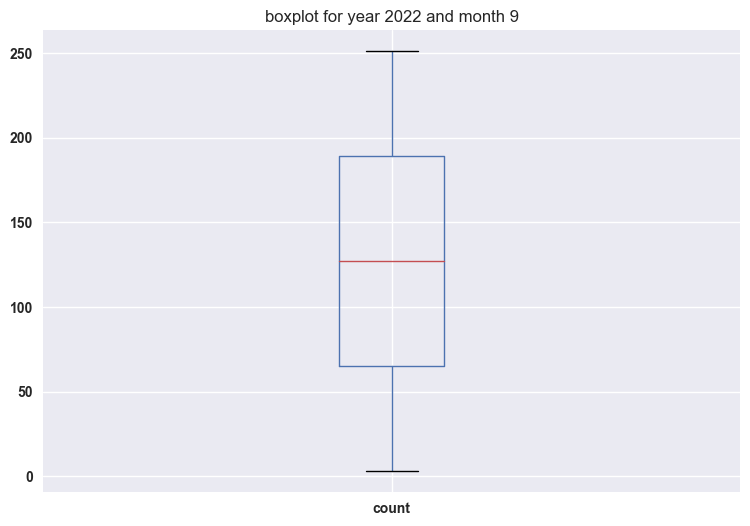

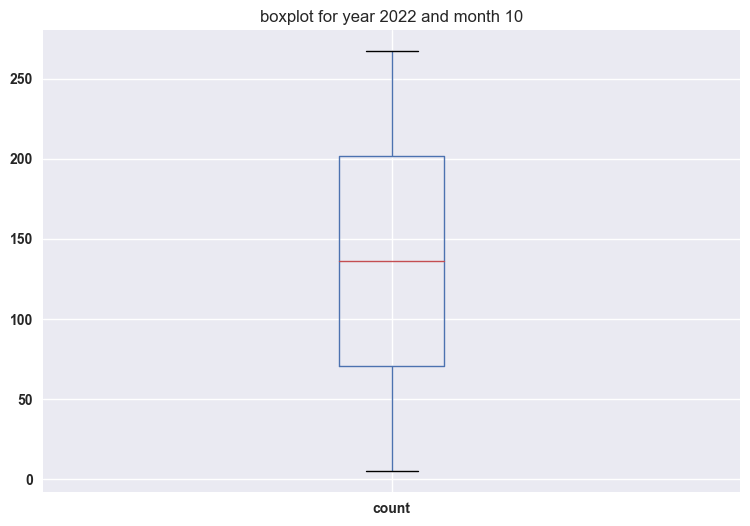

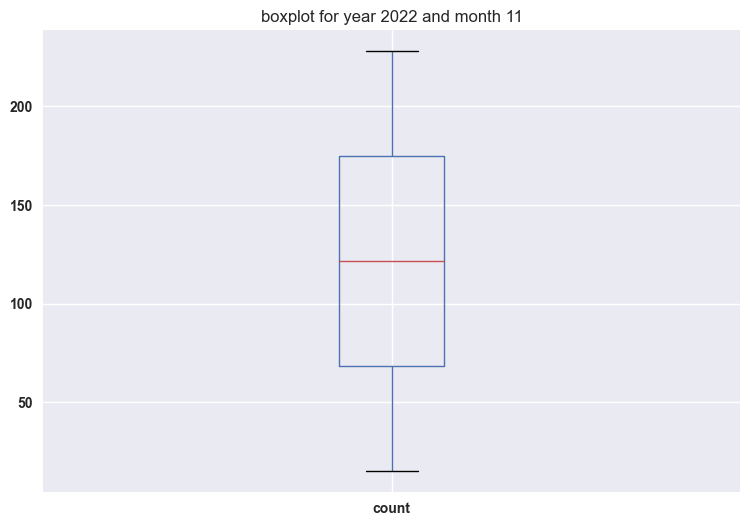

In [22]:
for year in range(2016, 2023):
    for month in range(1,12):
        plt.figure(figsize=(9, 6))
        (df[(df.date >= f'{year}-{month}-01') & (df.date <= f'{year}-{month + 1}-02')].groupby(df.date.dt.strftime('%Y-%m')).sum()).drop(columns=['week'], axis=1).boxplot()
        plt.title(f'boxplot for year {year} and month {month}')
        plt.show()

## Time Series Analysis

### Stationarity Check

In [23]:
def stationarity_check(ts):
            
    # Calculate rolling statistics
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()

    # Perform the Dickey Fuller test
    dftest = sts.adfuller(ts) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results

    print('\nResults of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [152]:
data = df.groupby(df.Date).sum() 
data.drop(columns=['week'], axis=1, inplace=True)
data 

,count
Date,
2016-01-01,1
2016-01-02,8
2016-01-03,8
2016-01-04,12
2016-01-05,4
...,...
2022-12-27,2
2022-12-28,4
2022-12-29,13


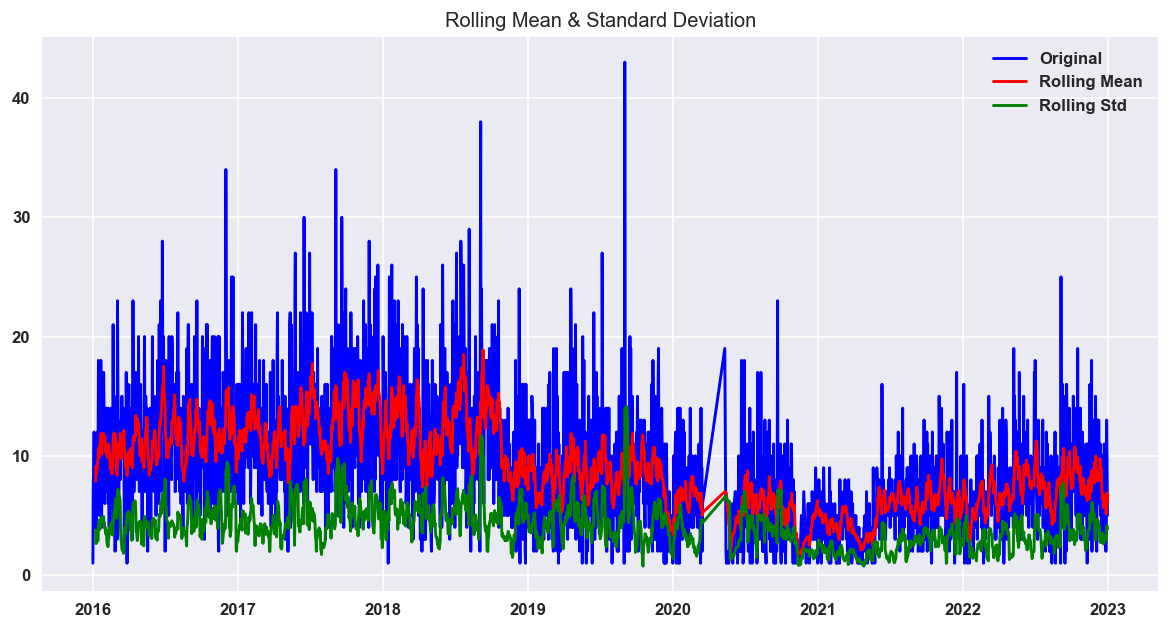


Results of Dickey-Fuller Test: 

Test Statistic                   -2.854713
p-value                           0.050873
#Lags Used                       27.000000
Number of Observations Used    2419.000000
Critical Value (1%)              -3.433056
Critical Value (5%)              -2.862736
Critical Value (10%)             -2.567406
dtype: float64


In [153]:
stationarity_check(data)

In [158]:
# Decomposition
def decomposition_plot(ts):
# Apply seasonal_decompose 
    decomposition = seasonal_decompose(np.log(ts), period=int(len(ts)/2))
    
# Get trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
# Plotting
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

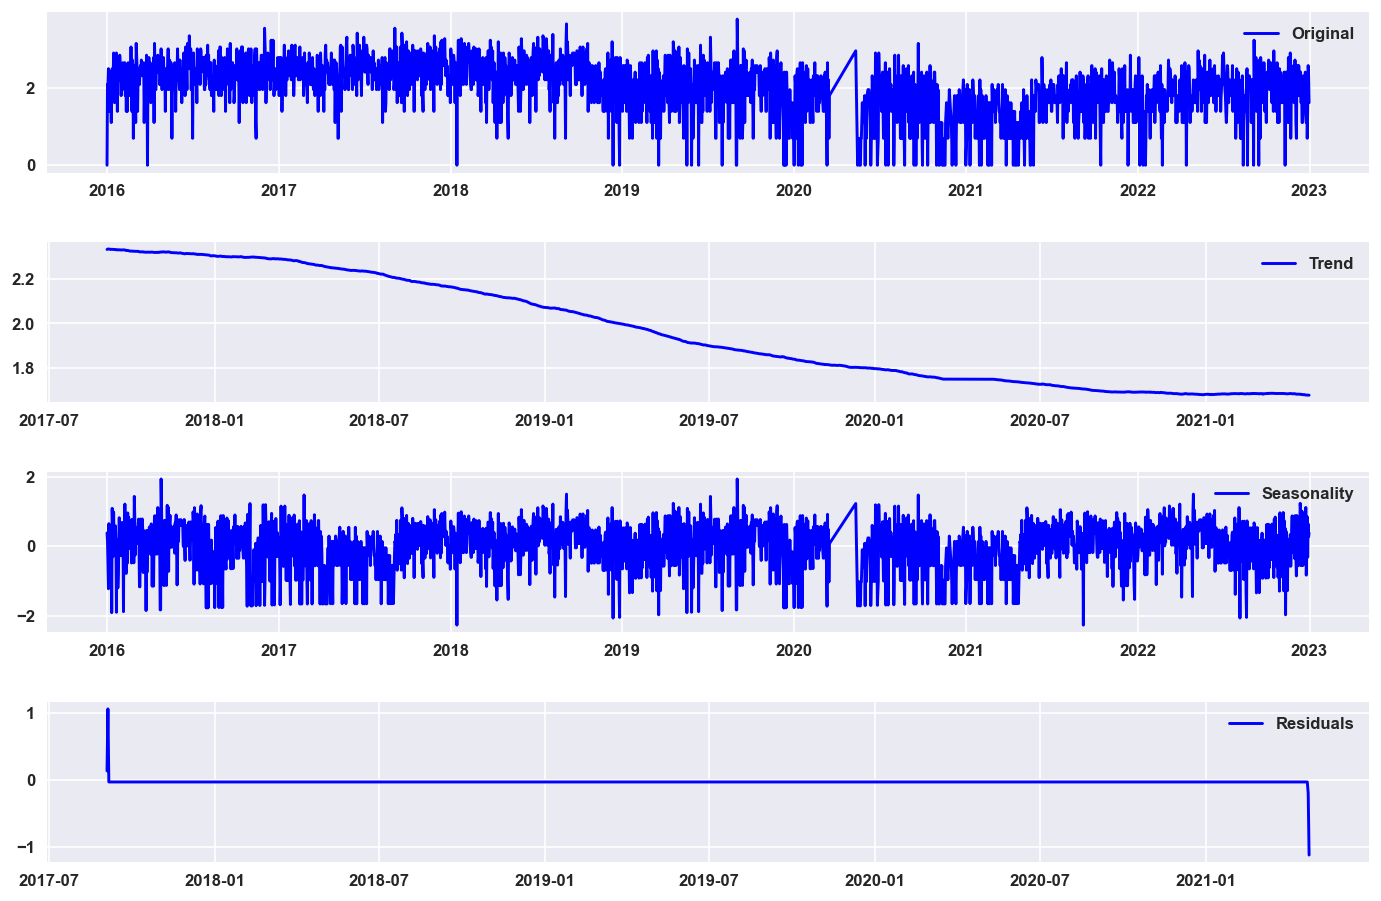

In [159]:
decomposition_plot(data)

In [170]:
decomposition = seasonal_decompose(np.log(data), period=int(len(data)/2))

In [171]:
trend = decomposition.trend.dropna(inplace=True)
seasonal = decomposition.seasonal.dropna(inplace=True)
residual = decomposition.resid.dropna(inplace=True)

In [172]:
stationarity_check(residual)

AttributeError: 'NoneType' object has no attribute 'rolling'

In [24]:
model_year_month = pm.auto_arima(df.groupby(df.date.dt.strftime('%Y-%m')).sum()['count'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model_year_month.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=868.754, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=874.961, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=872.317, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=869.305, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=872.996, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=870.596, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=870.570, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=868.657, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=870.574, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=872.504, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=866.825, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=867.392, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=868.759, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=868.760, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=866.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   83
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -430.412
Date:                Fri, 06 Jan 2023   AIC                            866.825
Time:                        10:59:34   BIC                            874.045
Sample:                             0   HQIC                           869.723
                                 - 83                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3275      0.117     -2.795      0.005      -0.557      -0.098
ma.L2         -0.1782      0.102     -1.754      0.080      -0.377       0.021
sigma2      2115.5164    269.995      7.835      0.000    1586.335    2644.697
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.02
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.83
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

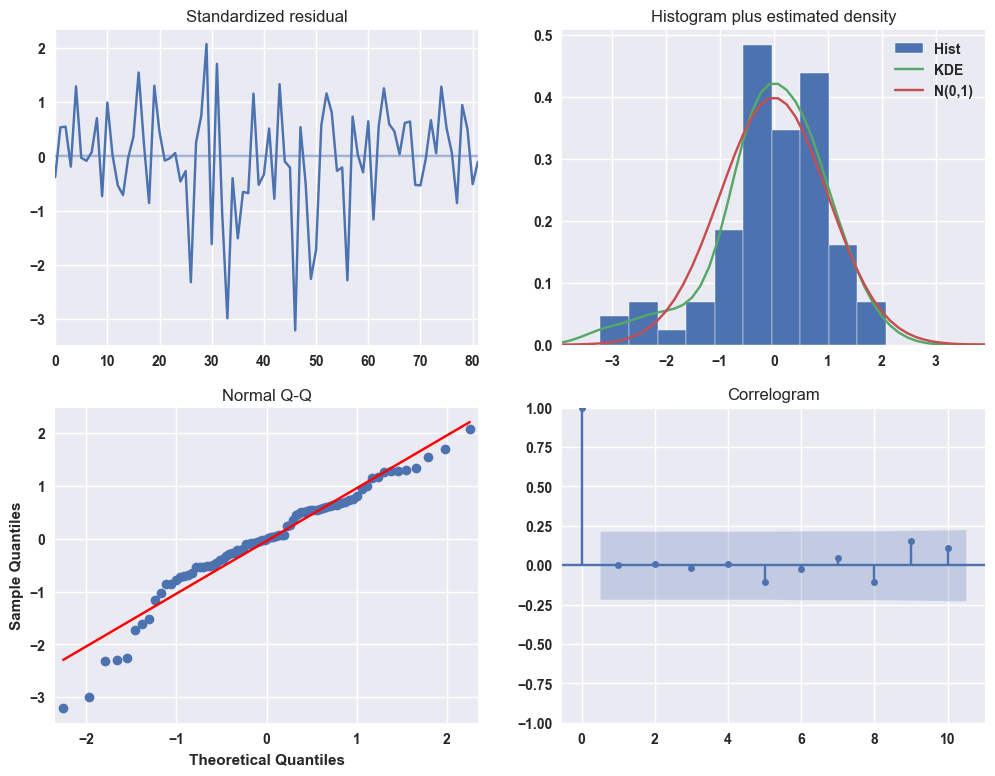

In [25]:
model_year_month.plot_diagnostics(figsize=(12,9))
plt.show()

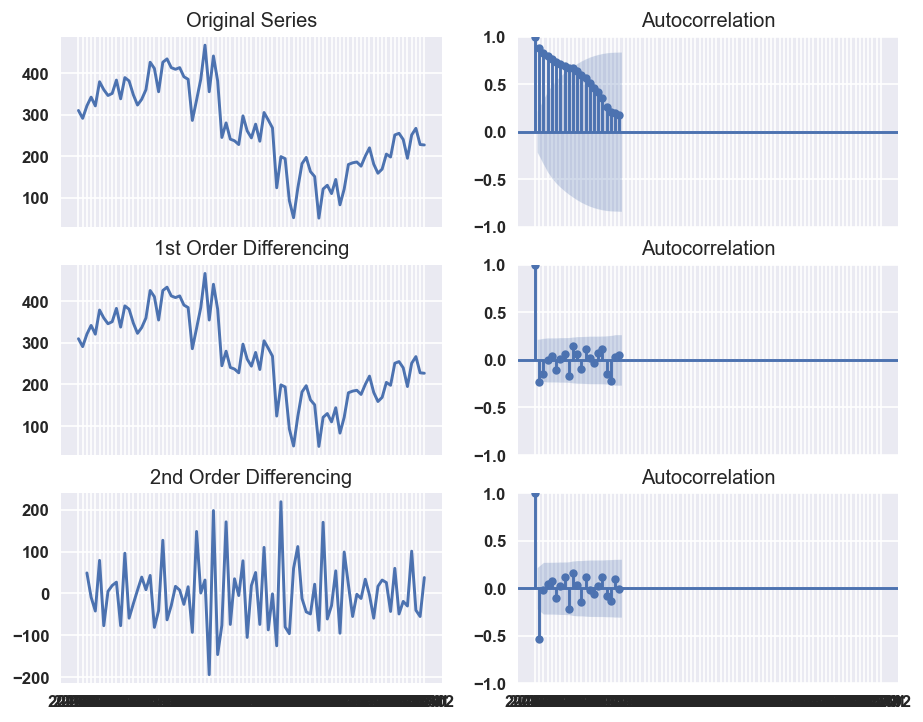

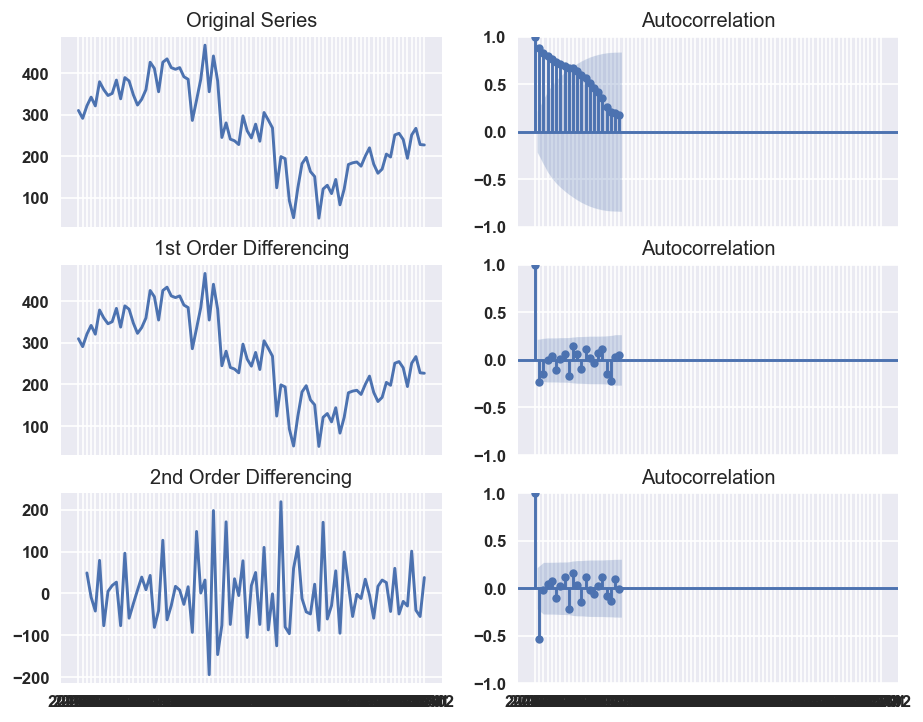

In [26]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

ts = df.groupby(df.date.dt.strftime('%Y-%m')).sum()['count']
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(ts); axes[0, 0].set_title('Original Series')
plot_acf(ts, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(ts); axes[1, 0].set_title('1st Order Differencing')
plot_acf(ts.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(ts.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(ts.diff().diff().dropna(), ax=axes[2, 1])

In [27]:
import pmdarima as pm
from darts.models.forecasting.xgboost import XGBModel
from darts.metrics.metrics import mse, marre, mae, dtw_metric
from darts import TimeSeries
from darts.models import AutoARIMA
from darts.models import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit

In [32]:
df_year_month = df.groupby(df.date.dt.strftime('%Y-%m')).sum().reset_index()
df_year_month.drop(columns=['week'], inplace=True, axis=1)

In [33]:
df_year_month

,date,count
0,2016-01,310
1,2016-02,291
2,2016-03,321
3,2016-04,342
4,2016-05,321
...,...,...
78,2022-08,195
79,2022-09,251
80,2022-10,267
81,2022-11,228


In [34]:
X = df_year_month['date']
y = df_year_month['count']

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [35]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

In [36]:
n_diffs

1

In [37]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=743.901, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=741.718, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=739.364, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=741.945, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=739.360, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=741.333, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=741.326, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=739.484, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=740.941, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=737.808, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=737.515, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=737.819, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=739.791, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=739.745, 

In [38]:
print(auto.order)

(0, 1, 1)


In [39]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto  

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 957.041535112741
SMAPE: 12.370383596709983


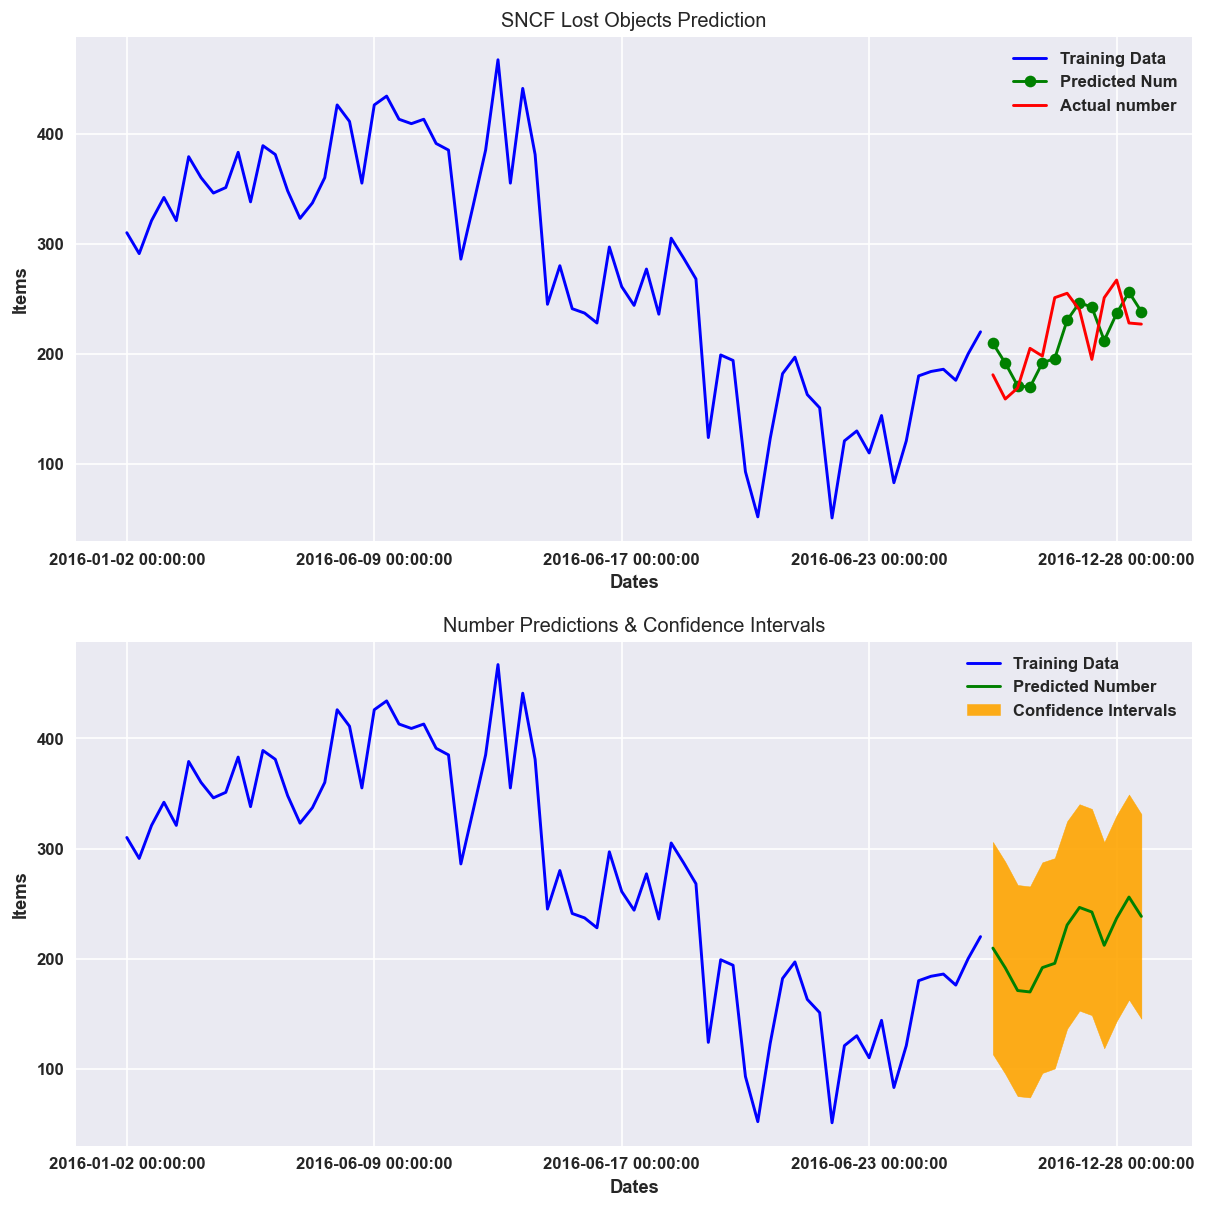

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(X_test.index, forecasts, color='green', marker='o',
             label='Predicted Num')

axes[0].plot(X_test.index, y_test, color='red', label='Actual number')
axes[0].set_title('SNCF Lost Objects Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Items')

axes[0].set_xticks(np.arange(0, 100, 20).tolist(), df['Date'][0:100:20].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(X_test.index, forecasts, color='green',
             label='Predicted Number')

axes[1].set_title('Number Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Items')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(X_test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].set_xticks(np.arange(0, 100, 20).tolist(), df['Date'][0:100:20].tolist())
axes[1].legend()

In [126]:
xgb_data = df[['Date', 'month', 'year', 'week', 'day', 'count']]

In [127]:
xgb_data

,Date,month,year,week,day,count
0,2016-01-02,1,2016,53,2,1
1,2016-01-02,1,2016,53,2,1
2,2016-01-03,1,2016,53,3,1
3,2016-01-03,1,2016,53,3,1
4,2016-01-04,1,2016,1,4,1
...,...,...,...,...,...,...
22204,2022-07-26,7,2022,30,26,1
22205,2022-07-26,7,2022,30,26,1
22206,2022-07-27,7,2022,30,27,1
22207,2022-07-27,7,2022,30,27,1


In [128]:
xgb_data = xgb_data.groupby(xgb_data.Date.dt.strftime('%Y-%m-%d')).sum().reset_index()
xgb_data.drop(columns=['week'], inplace=True, axis=1)

xgb_data

,Date,count
0,2016-01-01,1
1,2016-01-02,8
2,2016-01-03,8
3,2016-01-04,12
4,2016-01-05,4
...,...,...
2442,2022-12-27,2
2443,2022-12-28,4
2444,2022-12-29,13
2445,2022-12-30,10


In [129]:
xgb_data['Date'] = pd.to_datetime(xgb_data['Date'])

In [130]:
xgb_data.dtypes

Date     datetime64[ns]
count             int64
dtype: object

In [131]:
xgb_data['dayofweek'] = xgb_data['Date'].dt.day_of_week
xgb_data['quarter'] = xgb_data['Date'].dt.quarter
xgb_data['dayofyear'] = xgb_data['Date'].dt.day_of_year
xgb_data['weekofyear'] = xgb_data['Date'].dt.weekofyear

In [132]:
X = xgb_data.drop(columns='count', axis=1)
y = xgb_data['count']


In [135]:
split_date = '2022-01-10'
data_train = xgb_data.loc[xgb_data.Date <= pd.to_datetime(split_date)].copy()
data_test = xgb_data.loc[xgb_data.Date > pd.to_datetime(split_date)].copy()

In [137]:
data_train.set_index('Date', inplace=True)
data_test.set_index('Date', inplace=True)

In [139]:
X_train,  y_train = data_train.drop(columns='count', axis=1), data_train['count']
X_test,  y_test = data_test.drop(columns='count', axis=1), data_test['count']

In [140]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [141]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [142]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

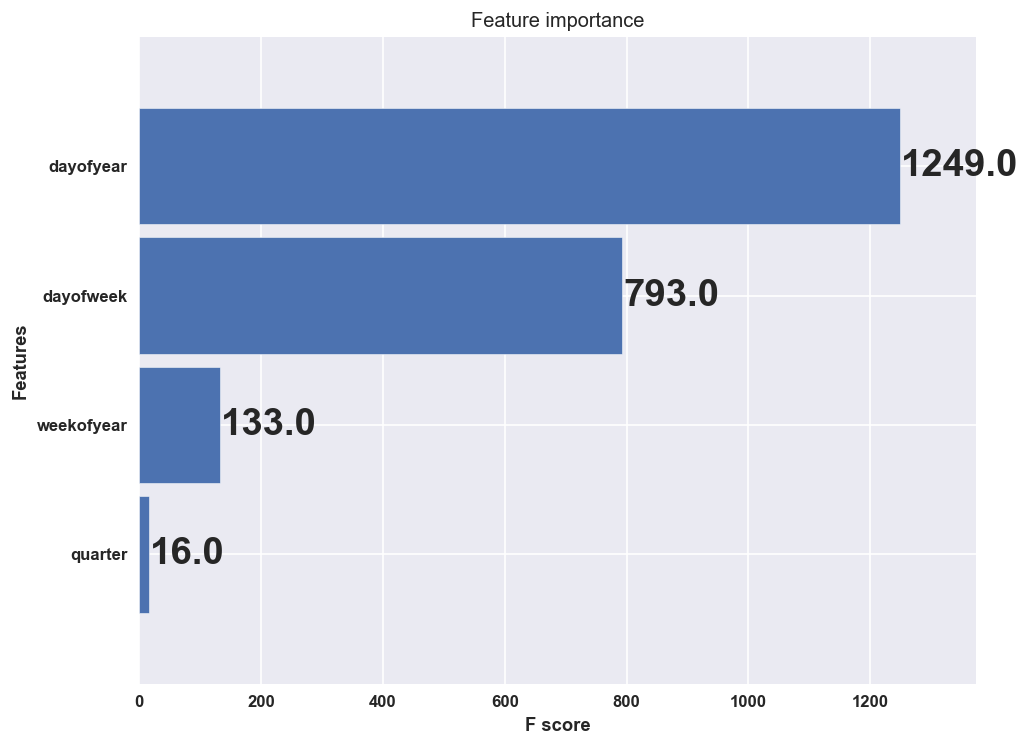

In [143]:
_ = plot_importance(reg, height=0.9)

In [144]:
data_test['number_Prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

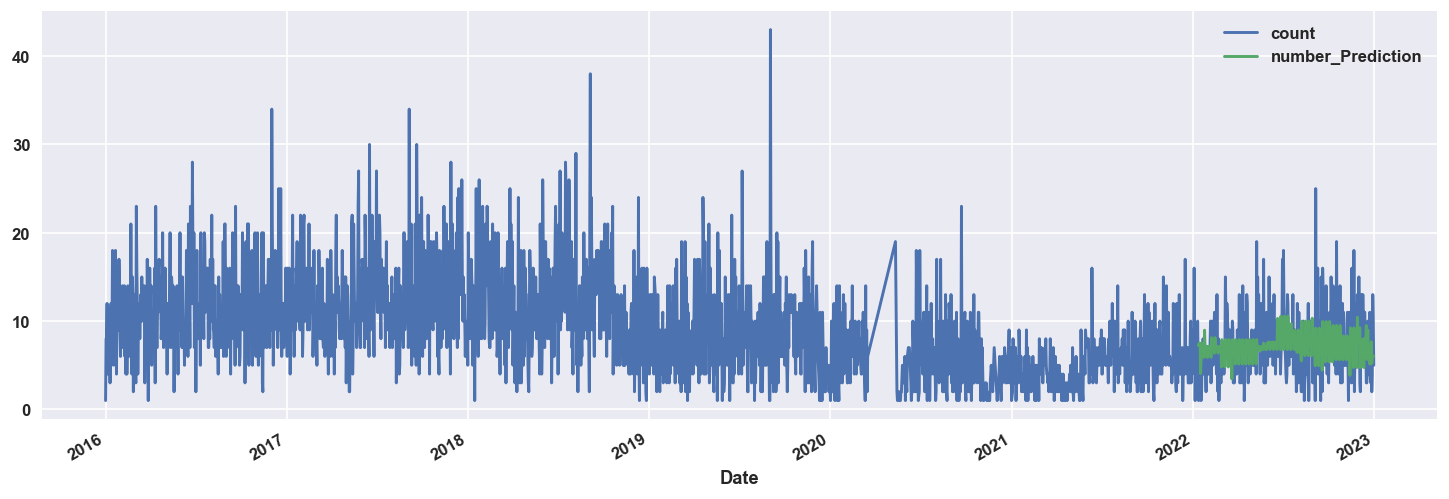

In [146]:
_ = data_all[['count','number_Prediction']].plot(figsize=(15, 5))

In [175]:
mse = mean_squared_error(y_test, reg.predict(X_test))
mae = mean_absolute_error(y_test, reg.predict(X_test))
mse, mae

(12.086861422647555, 2.7084440962742953)